## Step 1: Import Necessary Libraries
Start by importing required libraries, including CasADi for symbolic computation.

In [1]:
import casadi as ca
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from casadi import vertcat, diagcat, SX
from time import time


## Step 2: Define Problem Parameters
Set up the prediction horizon, time step, and other constants.

In [2]:
days = 2          
hours = 24 * days
state_interval_minutes = 60           
step_horizon = state_interval_minutes / 60
total_states = int(hours * (60 / state_interval_minutes))

horizen_hours = 24        
N = int(horizen_hours * (60 / state_interval_minutes))
total_time = days * 24 * 3600  # number of days in seconds

### system parameters

In [3]:
# System parameters

# === Electrical Energy Storage System (ESS) ===
SOES_init = 1000            # ESS initial state [kWh]
SOES_min, SOES_max = 200, 2500  # ESS storage bounds [kWh]
P_e_ch_min, P_e_ch_max = 0, 500    # ESS charge power bounds [kW]
P_e_dis_min, P_e_dis_max = 0, 500  # ESS discharge power bounds [kW]
eta_ech = 0.9               # ESS charge efficiency (unitless)
eta_edis = 0.92              # ESS discharge efficiency (unitless)
gamma_e = 0.999             # ESS storage retention factor per time step (unitless)

# === Thermal Energy Storage System (TSS) ===
SOTS_init = 600             # TSS initial state [kWh]
SOTS_min, SOTS_max = 180, 1080  # TSS storage bounds [kWh]
P_h_ch_min, P_h_ch_max = 0, 300     # TSS charge power bounds [kW]
P_h_dis_min, P_h_dis_max = 0, 300   # TSS discharge power bounds [kW]
eta_hch = 0.95              # TSS charge efficiency
eta_hdis =0.95             # TSS discharge efficiency
gamma_h = 0.999             # TSS storage retention factor per time step

# === Ice/Cooling Storage (ICS) ===
SOCS_init = 540             # ICS initial state [kWh]
SOCS_min, SOCS_max = 180, 900    # ICS storage bounds [kWh]
P_c_ch_min, P_c_ch_max = 0, 240    # ICS charge power bounds [kW]
P_c_dis_min, P_c_dis_max = 0, 240  # ICS discharge power bounds [kW]
eta_cch = 0.95              # ICS charge efficiency
eta_cdis = 0.95             # ICS discharge efficiency
gamma_i = 0.999             # ICS storage retention factor per time step

# === Gas Storage (GSS) ===
SOGS_init = 200             # Gas storage initial state [kWh] (or kWh-equivalent / Nm3 depending on units)
SOGS_min, SOGS_max = 40, 400     # Gas storage bounds [kWh]
P_g_ch_min, P_g_ch_max = 0, 100    # Gas storage charge power bounds [kW]
P_g_dis_min, P_g_dis_max = 0, 100  # Gas storage discharge power bounds [kW]
eta_gch = 0.95               # Gas storage charge efficiency
eta_gdis = 0.95              # Gas storage discharge efficiency
gamma_g = 1             # Gas storage retention factor per time step

# Collect gammas (if you use a vector of retention factors)
gamma = ca.diagcat(gamma_e, gamma_h, gamma_i, gamma_g)


# System Modelation

In [4]:

# Gas boiler model 
P_h_GB_min, P_h_GB_max = 0.0, 1000.0 # GB heat output [kW]
eta_GB = 0.9  # Efficiency of the gas boiler
P_g_GB_min, P_g_GB_max = P_h_GB_min/eta_GB,  P_h_GB_max/eta_GB # Gas input limits [kW]

# Electric Boiler model 
P_h_EB_min, P_h_EB_max = 0.0, 500.0  # Heat output [kW]
eta_EB = 0.95
P_e_EB_min, P_e_EB_max = P_h_EB_min / eta_EB, P_h_EB_max / eta_EB  # Electric input [kW]

 
# Electric chiller model
P_c_EC_min, P_c_EC_max = 0.0, 2100.0  # Cooling output [kW]
COP_EC = 4.0  # Electric chiller efficiency
P_e_EC_min, P_e_EC_max = P_c_EC_min / COP_EC, P_c_EC_max / COP_EC  # Electric input [kW]


# absorption chiller model 
P_h_AC_min, P_h_AC_max = 0.0, 1500.0  # Heat input [kW]
COP_AC = 0.8
P_c_AC_min, P_c_AC_max = P_h_AC_min * COP_AC, P_h_AC_max * COP_AC  # Cooling output [kW]


# CHP model (Eq. 21–24) 
P_e_CHP_min, P_e_CHP_max = 0.0, 800.0  # Electric output [kW]
eta_e_CHP = 0.364
eta_h_CHP = 0.364
P_h_CHP_min, P_h_CHP_max = P_e_CHP_min * eta_h_CHP / eta_e_CHP, P_e_CHP_max * eta_h_CHP / eta_e_CHP
P_g_CHP_min, P_g_CHP_max = P_e_CHP_min / eta_e_CHP, P_e_CHP_max / eta_e_CHP
# P_e_A, P_e_B, P_e_C, P_e_D = 380.0, 315.0, 745.0, 800.0
# P_h_A, P_h_B, P_h_C, P_h_D = 0.0, 515.0, 1220.0, 0.0


# PV model 

P_PV_min, P_PV_max = 0.0, 200.0
alpha = 1


# Grid interaction constraints  
P_g_buy_min, P_g_buy_max = 0.0, 3000 # Gas purchase parameters
P_e_buy_min, P_e_buy_max = 0.0, 3000 # Electricity purchase parameters
P_e_sell_min, P_e_sell_max = 0.0, 3000.0 # Electricity sale parameters


In [5]:
# Reading the CSV in another script
df = pd.read_csv('data1.csv')
df.set_index('Time (Hours)', inplace=True)

# # Example: Print and plot the loaded data
# print("\nLoaded Data from CSV:")
# print(read_data.head())

### + Electrical Load
electrical_load = df['Electrical Load (kW)']
#print(electrical_load)

### + Heating Load
heat_load = df['Heating Load (kW)']
#print(heat_load)


### + Cooling Load
cool_load = df['Cooling Load (kW)']
#print(cool_load)

#print("Hello")

### + Electricity buy cost
ce_buy = df['Elec_buy_cost']
#print(ce_buy)

### + Gas buy cost
cg_buy = df['Gas_buy_cost']
#print(cg_buy)

# Costs
ce_sell = 0.12  # Costs for electricity sold to the grid

### + PV
P_pv = df['PV Output Power (kW)']
#print(P_pv)




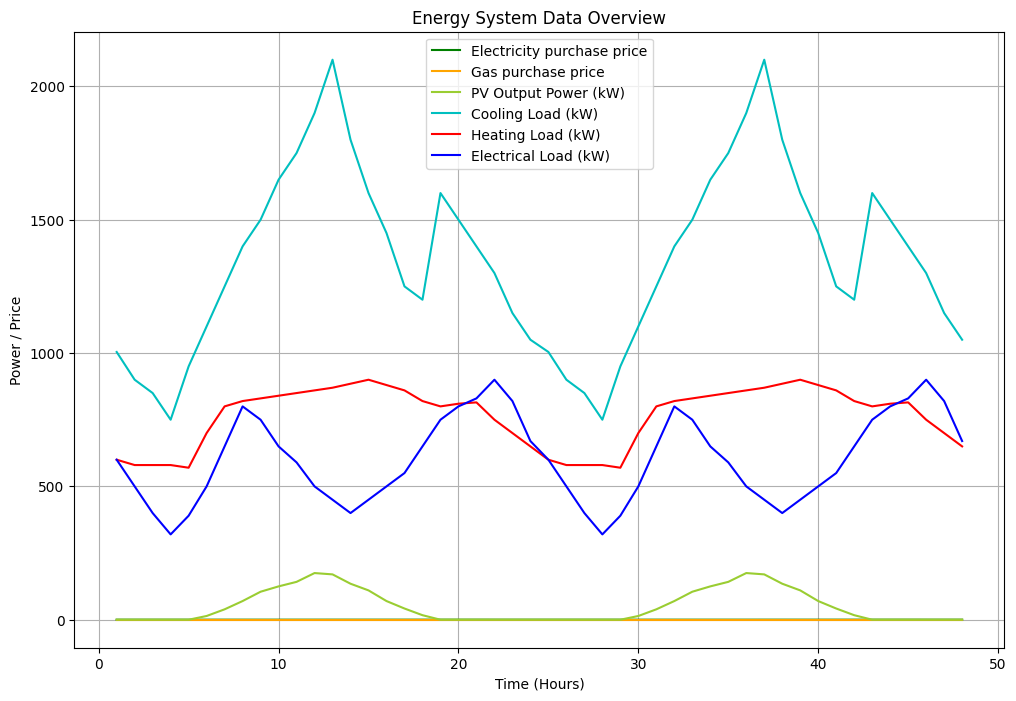

In [6]:
plt.figure(figsize=(12,8))

plt.plot(df.index, ce_buy, label='Electricity purchase price', linestyle='-', color='green')
plt.plot(df.index, cg_buy, label='Gas purchase price', linestyle='-', color='orange')
plt.plot(df.index, P_pv, label='PV Output Power (kW)', linestyle='-', color='yellowgreen')
plt.plot(df.index, df['Cooling Load (kW)'], label='Cooling Load (kW)', linestyle='-', color='c')
plt.plot(df.index, df['Heating Load (kW)'], label='Heating Load (kW)', linestyle='-', color='r')
plt.plot(df.index, electrical_load, label='Electrical Load (kW)', linestyle='-', color='b')

plt.xlabel('Time (Hours)')
plt.ylabel('Power / Price')
plt.title('Energy System Data Overview')
plt.legend()
plt.grid(True)
plt.show()

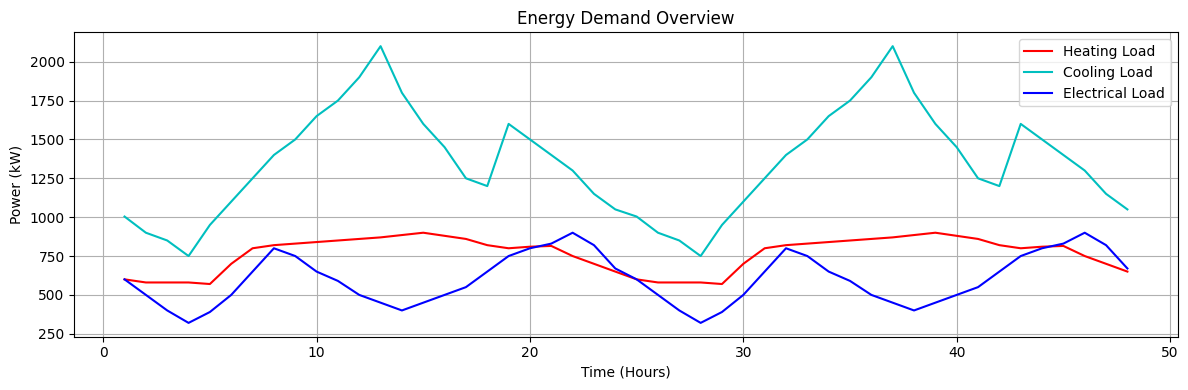

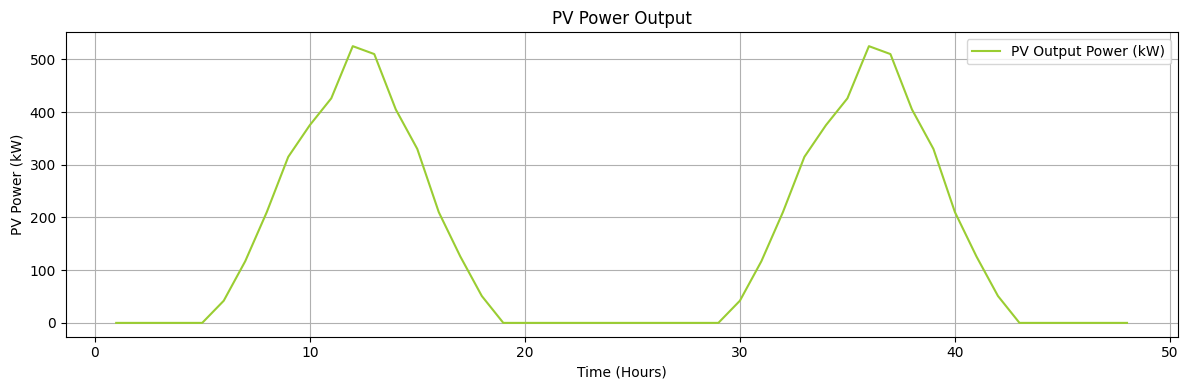

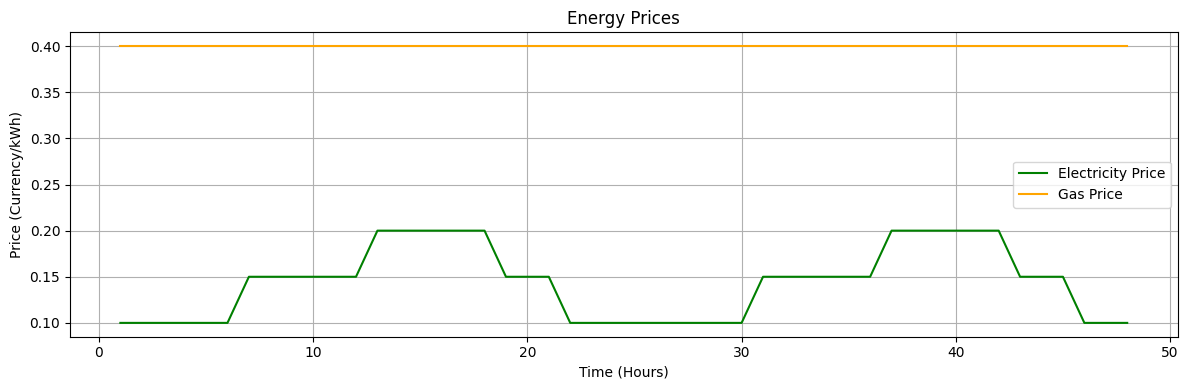

In [7]:
import matplotlib.pyplot as plt

# ---- 1. Load / Consumption ----
plt.figure(figsize=(12,4))
plt.plot(df.index, df['Heating Load (kW)'], label='Heating Load', color='r')
plt.plot(df.index, df['Cooling Load (kW)'], label='Cooling Load', color='c')
plt.plot(df.index, electrical_load, label='Electrical Load', color='b')
plt.xlabel('Time (Hours)')
plt.ylabel('Power (kW)')
plt.title('Energy Demand Overview')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('Energy_Demand_Overview.png')


# ---- 2. PV Output ----
plt.figure(figsize=(12,4))
plt.plot(df.index, 3*P_pv, label='PV Output Power (kW)', color='yellowgreen')
plt.xlabel('Time (Hours)')
plt.ylabel('PV Power (kW)')
plt.title('PV Power Output')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('pv_output.png')  


# ---- 3. Prices ----
plt.figure(figsize=(12,4))
plt.plot(df.index, ce_buy, label='Electricity Price', color='green')
plt.plot(df.index, cg_buy, label='Gas Price', color='orange')
plt.xlabel('Time (Hours)')
plt.ylabel('Price (Currency/kWh)')
plt.title('Energy Prices')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('energy_prices.png')  



## Step 3: Define Variables
Define symbolic variables for states, controls, and parameters.

In [8]:
# Control variables
SOE_e = ca.SX.sym('SOE_e')  # Electric storage level
SOE_h = ca.SX.sym('SOE_h')  # Thermal storage level
SOE_i = ca.SX.sym('SOE_i')  # Ice storage level
SOE_g = ca.SX.sym('SOE_g')  # Gas storage level


# states = vertcat(SOE_e)
states = ca.vertcat(SOE_e, SOE_h, SOE_i, SOE_g)  # Control variables combined

# State variables 
P_g_buy = ca.SX.sym('P_g_buy') # Natural Gas purchased from the grid
P_e_buy = ca.SX.sym('P_e_buy')  # Electricity purchased from the grid
P_e_sell = ca.SX.sym('P_e_sell')  # Electricity sold to the grid


P_ch_h = ca.SX.sym('P_ch_h')  # Thermal charging power
P_dis_h = ca.SX.sym('P_dis_h')  # Thermal discharging power

P_ch_e = ca.SX.sym('P_ch_e')  # Electric charging power
P_dis_e = ca.SX.sym('P_dis_e')  # Electric discharging power

P_ch_g = ca.SX.sym('P_ch_g')     # Gas charging power
P_dis_g = ca.SX.sym('P_dis_g')   # Gas discharging power

P_ch_i = ca.SX.sym('P_ch_i')     # Ice charging power
P_dis_i = ca.SX.sym('P_dis_i')   # Ice discharging power


#P_PV_data = ca.SX.sym('P_PV_data', N)  # PV power output parameter


P_e_CHP = ca.SX.sym('P_e_CHP')  # CHP electric output
P_g_CHP = SX.sym('P_g_CHP')  # Heat power from CHP
P_h_CHP = ca.SX.sym('P_h_CHP')  # CHP heat output

P_h_GB = ca.SX.sym('P_h_GB')  # Gas boiler heat output
P_g_GB = SX.sym('P_g_GB')  # Gas input for gas boiler


P_h_EB = ca.SX.sym('P_h_EB')  # Electric boiler heat output
P_e_EB = ca.SX.sym('P_e_EB')  # Electric boiler electric input

P_c_EC = ca.SX.sym('P_c_EC')  # Electric chiller cooling power
P_e_EC = ca.SX.sym('P_e_EC')  # Electric chiller electric input

P_h_AC = ca.SX.sym('P_h_AC')  # Absorption chiller heat input (thermal energy)
P_c_AC = ca.SX.sym('P_c_AC')  # Absorption chiller cooling output

P_pv_output = ca.SX.sym('P_pv_output')   # PV power output

controls = ca.vertcat(
    # Energy purchase/sale from the grid
    P_g_buy,   # 0: Natural gas purchased from the grid
    P_e_buy,   # 1: Electricity purchased from the grid
    P_e_sell,  # 2: Electricity sold to the grid

    # Electric storage
    P_ch_e,    # 3: Electric storage charging power
    P_dis_e,   # 4: Electric storage discharging power

    
    # Thermal storage
    P_ch_h,    # 5: Thermal storage charging power
    P_dis_h,   # 6: Thermal storage discharging power

    # Ice storage
    P_ch_i,    # 7: Ice storage charging power
    P_dis_i,   # 8: Ice storage discharging power
    
    # Gas storage
    P_ch_g,    # 9: Gas storage charging power
    P_dis_g,   # 10: Gas storage discharging power


    # Combined Heat and Power (CHP) unit
    P_e_CHP,   # 11: CHP electric output
    P_g_CHP,   # 12: CHP gas input
    P_h_CHP,   # 13: CHP heat output

    # Gas boiler
    P_h_GB,    # 14: Gas boiler heat output
    P_g_GB,    # 15: Gas boiler gas input

    # Electric boiler
    P_h_EB,    # 16: Electric boiler heat output
    P_e_EB,    # 17: Electric boiler electric input

    # Electric chiller
    P_c_EC,    # 18: Electric chiller cooling output
    P_e_EC,    # 19: Electric chiller electric input

    # Absorption chiller
    P_h_AC,    # 20: Absorption chiller heat input
    P_c_AC,     # 21: Absorption chiller cooling output
    P_pv_output   # 22: # PV power output
)


## Step 4: Define System Dynamics
Define the energy storage dynamics and constraints.

In [9]:
# Energy storage dynamics for electricity
dynamics_electricity = (
    (eta_ech * P_ch_e - P_dis_e / eta_edis)
)

# Energy storage dynamics for thermal energy
dynamics_thermal = (
    (eta_hch * P_ch_h - P_dis_h / eta_hdis)
)

# Energy storage dynamics for ice
dynamics_ice = (
    (eta_cch * P_ch_i - P_dis_i / eta_cdis)
)

# Energy storage dynamics for gas
dynamics_gas = (
    (eta_gch * P_ch_g - P_dis_g / eta_gdis)
)

# Combine all updated dynamics into a single vector
dynamics = vertcat(dynamics_electricity, dynamics_thermal, dynamics_ice, dynamics_gas)


## Step 6: MPC Formulation
Formulate the MPC problem using CasADi.

In [10]:
# Optimization variables    # Like robotic mpc code:
n_states = states.numel()
n_controls = controls.numel()
X = ca.SX.sym('X', n_states, N + 1) # matrix containing all states over all time steps +1 (each column is a state vector)
U = ca.SX.sym('U', n_controls, N) # matrix containing all control actions over all time steps (each column is an action vector)
P = ca.SX.sym('P', n_states + n_states + 6*N) # coloumn vector for storing initial state and target state

print(n_states, n_controls)


4 23


In [11]:
# #                       0       1          2        3       4       5      6        7        8       9      10           11      12      13         14      15    16       17     18       19      20      21        22
# # controls = vertcat(P_g_buy, P_e_buy, P_e_sell, P_ch_e, P_dis_e, P_ch_h, P_dis_h, P_ch_i, P_dis_i, P_ch_g, P_dis_g,  P_e_CHP, P_g_CHP, P_h_CHP, P_h_GB, P_g_GB, P_h_EB, P_e_EB, P_c_EC, P_e_EC, P_h_AC, P_c_AC, P_pv_output)

In [12]:
# Initialize the constraint symbolic expression
g = SX()


for k in range(N): # maybe N+1 for X
    
    ### Electric storage constraints
    g = vertcat(g, U[3,k] * U[4,k]) # No simultaneous charging and discharging (equality constraint)    #7  ###1
    ### Thermal storage constraints 
    g = vertcat(g, U[5,k] * U[6,k]) # No simultaneous charging and discharging (equality constraint)    #14                                     ###2
    ### Ice storage constraints
    g = vertcat(g, U[7,k] * U[8,k]) # No simultaneous charging and discharging (equality constraint)    #7  ###1
    ### Gas storage constraints 
    g = vertcat(g, U[9,k] * U[10,k]) # No simultaneous charging and discharging (equality constraint)    #14                                     ###2
    
    
    g = vertcat(g, U[1,k] * U[2,k]) ## Buying and selling cannot occur simultaneously.
    
    ### CHP
    g = vertcat(g, U[11,k] - eta_e_CHP * U[12,k])
    g = vertcat(g, U[13,k] - eta_h_CHP * U[12,k])
    
    ### Gas boiler model
    g = vertcat(g, U[14,k] - eta_GB * U[15,k]) # Gas boiler relationg (equality constraint)  #15                                                 ###3
   
    ### Electric Boiler
    g = vertcat(g, U[16,k] - eta_EB * U[17,k])
    
    ### Electric chiller
    g = vertcat(g, U[18,k] - COP_EC * U[19,k])

    ### Absorption Chiller
    g = vertcat(g, U[21,k] - COP_AC * U[20,k])
    
    ### PV
    g = vertcat(g, U[22,k] - alpha *P[2*n_states+5*N+k] )


    ### Energy Balance equalities
    
    # Gas
    g = vertcat(g,
    U[0,k]                         # Gas purchased
    + (U[10,k] - U[9,k])           # charge - decharge
    - U[12,k] - U[15,k])             # Consumption, CHP and GB


    # Electricity
    g = vertcat(g,
    - P[2*n_states+2*N+k]         #Electrical load
    + U[1,k] - U[2,k]             # Net grid electricity
    + U[11,k]                     # production CHP
    + (U[4,k] - U[3,k])           # charge - decharge
    + U[22,k]        # PV
    - U[17,k] - U[19,k])           # Consumption, EB and EC


    # Heat
    g = vertcat(g,
    - P[2*n_states+k]             # Heat load
    + U[13,k] + U[14,k] + U[16,k] # Sources
    + (U[6,k] - U[5,k])           # charge - decharge
    - U[20,k])                      # AC consuming


    # Cool
    g = vertcat(g,
    - P[2*n_states+N+k]           # needed
    + U[18,k] + U[21,k]           # sources 
    + (U[8,k] - U[7,k]))            # charge - decharge




In [13]:
# #                       0       1          2        3       4       5      6        7        8       9      10           11      12      13         14      15    16       17     18       19      20      21
# # controls = vertcat(P_g_buy, P_e_buy, P_e_sell, P_ch_e, P_dis_e, P_ch_h, P_dis_h, P_ch_i, P_dis_i, P_ch_g, P_dis_g,  P_e_CHP, P_g_CHP, P_h_CHP, P_h_GB, P_g_GB, P_h_EB, P_e_EB, P_c_EC, P_e_EC, P_h_AC, P_c_AC)

# # Initialize cost and constraints over the prediction horizon
total_cost = 0  # cost function

f = ca.Function('f', [states, controls], [dynamics])

X[:, 0] = P[:n_states] #setting the initial states

for k in range(N):
    st = X[:, k]
    con = U[:, k]
    
        
    ce_buy_k = P[2*n_states+3*N+k]
    cg_buy_k = P[2*n_states+4*N+k]
    
    total_cost = total_cost + ((ce_buy_k * con[1]) - (ce_sell * con[2]) + (cg_buy_k * con[0]))     # Add cost function contribution

    st_next_expected = gamma @ st + step_horizon * f(st, con)
    X[:, k+1] = st_next_expected


for k in range(N+1):
    g = vertcat(g, X[0,k])  # SOE_e
    g = vertcat(g, X[1,k])  # SOE_h
    g = vertcat(g, X[2,k])  # SOE_i
    g = vertcat(g, X[3,k])  # SOE_g
    

ff = ca.Function('ff', [U, P], [X])


OPT_variables = ca.vertcat(
    U.reshape((-1, 1))
)

# Define the NLP problem
nlp_prob = {
    'f': total_cost,
    'x': OPT_variables,
    'g': g,
    'p': P
}

# Solver settings
opts = {
    'ipopt': {
        'max_iter': 20000,  # Maximum iterations
        'print_level': 5,  # Suppress solver output
        'tol': 1e-6,       # Tolerance for convergence  ###??? it is not in robotic mpc code
        'acceptable_tol': 1e-6,
        'acceptable_obj_change_tol': 1e-6,
    },
    'print_time': 5
}

# Create solver
solver = ca.nlpsol('solver', 'ipopt', nlp_prob, opts)

# X[:, 0] - P[:n_states]
nlp_prob
# g


{'f': SX(@1=0.12, ((((((((((((((((((((((((((P_80*U_1)-(@1*U_2))+(P_104*U_0))+(((P_81*U_24)-(@1*U_25))+(P_105*U_23)))+(((P_82*U_47)-(@1*U_48))+(P_106*U_46)))+(((P_83*U_70)-(@1*U_71))+(P_107*U_69)))+(((P_84*U_93)-(@1*U_94))+(P_108*U_92)))+(((P_85*U_116)-(@1*U_117))+(P_109*U_115)))+(((P_86*U_139)-(@1*U_140))+(P_110*U_138)))+(((P_87*U_162)-(@1*U_163))+(P_111*U_161)))+(((P_88*U_185)-(@1*U_186))+(P_112*U_184)))+(((P_89*U_208)-(@1*U_209))+(P_113*U_207)))+(((P_90*U_231)-(@1*U_232))+(P_114*U_230)))+(((P_91*U_254)-(@1*U_255))+(P_115*U_253)))+(((P_92*U_277)-(@1*U_278))+(P_116*U_276)))+(((P_93*U_300)-(@1*U_301))+(P_117*U_299)))+(((P_94*U_323)-(@1*U_324))+(P_118*U_322)))+(((P_95*U_346)-(@1*U_347))+(P_119*U_345)))+(((P_96*U_369)-(@1*U_370))+(P_120*U_368)))+(((P_97*U_392)-(@1*U_393))+(P_121*U_391)))+(((P_98*U_415)-(@1*U_416))+(P_122*U_414)))+(((P_99*U_438)-(@1*U_439))+(P_123*U_437)))+(((P_100*U_461)-(@1*U_462))+(P_124*U_460)))+(((P_101*U_484)-(@1*U_485))+(P_125*U_483)))+(((P_102*U_507)-(@1*U_508))+(P

## Step 7: Solve the Optimization Problem
Solve using IPOPT from CasADi.

In [14]:
# #                       0       1          2        3       4       5      6        7        8       9      10           11      12      13         14      15    16       17     18       19      20      21
# # controls = vertcat(P_g_buy, P_e_buy, P_e_sell, P_ch_e, P_dis_e, P_ch_h, P_dis_h, P_ch_i, P_dis_i, P_ch_g, P_dis_g, P_e_CHP, P_g_CHP, P_h_CHP, P_h_GB, P_g_GB, P_h_EB, P_e_EB, P_c_EC, P_e_EC, P_h_AC, P_c_AC)

lbx = ca.DM.zeros((n_controls*N, 1))
ubx = ca.DM.zeros((n_controls*N, 1))

lbg = ca.DM.zeros(g.size1())  # Lower bounds for constraints -> All of them are equality functions
ubg = ca.DM.zeros(g.size1())  # Upper bounds for constraints -> All of them are equality functions

lbg[g.size1() - n_states*(N+1) + 0 :: n_states] = SOES_min    # Electric storage lower bound
ubg[g.size1() - n_states*(N+1) + 0 :: n_states] = SOES_max    # Electric storage upper bound


lbg[g.size1() - n_states*(N+1) + 1 :: n_states] = SOTS_min    # Thermal storage lower bound
ubg[g.size1() - n_states*(N+1) + 1 :: n_states] = SOTS_max    # Thermal storage upper bound

lbg[g.size1() - n_states*(N+1) + 2 :: n_states] = SOCS_min    # Ice storage lower bound
ubg[g.size1() - n_states*(N+1) + 2 :: n_states] = SOCS_max    # Ice storage upper bound


lbg[g.size1() - n_states*(N+1) + 3 :: n_states] = SOGS_min    # Gas storage lower bound
ubg[g.size1() - n_states*(N+1) + 3 :: n_states] = SOGS_max    # Gas storage upper bound



lbx[0: (0*n_states*(N*1) + n_controls*N): n_controls] = P_g_buy_min              # P_g_buy lower bound
ubx[0: (0*n_states*(N*1) + n_controls*N): n_controls] = P_g_buy_max              # P_g_buy upper bound


lbx[1: (0*n_states*(N+1) + n_controls*N): n_controls] = P_e_buy_min          # P_e_buy lower bound
ubx[1: (0*n_states*(N+1) + n_controls*N): n_controls] = P_e_buy_max          # P_e_buy upper bound


lbx[2: (0*n_states*(N+1) + n_controls*N): n_controls] = P_e_sell_min         # P_e_sell lower bound
ubx[2: (0*n_states*(N+1) + n_controls*N): n_controls] = P_e_sell_max         # P_e_sell upper bound


lbx[3: (0*n_states*(N+1) + n_controls*N): n_controls] = P_e_ch_min           # P_ch_e lower bound
ubx[3: (0*n_states*(N+1) + n_controls*N): n_controls] = P_e_ch_max           # P_ch_e upper bound


lbx[4: (0*n_states*(N+1) + n_controls*N): n_controls] = P_e_dis_min          # P_dis_e lower bound
ubx[4: (0*n_states*(N+1) + n_controls*N): n_controls] = P_e_dis_max          # P_dis_e upper bound

lbx[5: (0*n_states*(N+1) + n_controls*N): n_controls] = P_h_ch_min           # P_ch_h lower bound
ubx[5: (0*n_states*(N+1) + n_controls*N): n_controls] = P_h_ch_max           # P_ch_h upper bound


lbx[6: (0*n_states*(N+1) + n_controls*N): n_controls] = P_h_dis_min          # P_dis_h lower bound
ubx[6: (0*n_states*(N+1) + n_controls*N): n_controls] = P_h_dis_max          # P_dis_h upper bound


lbx[7: (0*n_states*(N+1) + n_controls*N): n_controls] = P_c_ch_min           # P_ch_i lower bound
ubx[7: (0*n_states*(N+1) + n_controls*N): n_controls] = P_c_ch_max           # P_ch_i upper bound


lbx[8: (0*n_states*(N+1) + n_controls*N): n_controls] = P_c_dis_min          # P_dis_h lower bound
ubx[8: (0*n_states*(N+1) + n_controls*N): n_controls] = P_c_dis_max          # P_dis_h upper bound


lbx[9: (0*n_states*(N+1) + n_controls*N): n_controls] = P_g_ch_min           # P_ch_i lower bound
ubx[9: (0*n_states*(N+1) + n_controls*N): n_controls] = P_g_ch_max           # P_ch_i upper bound


lbx[10: (0*n_states*(N+1) + n_controls*N): n_controls] = P_g_dis_min          # P_dis_g lower bound
ubx[10: (0*n_states*(N+1) + n_controls*N): n_controls] = P_g_dis_max          # P_dis_g upper bound



lbx[11: (0*n_states*(N+1) + n_controls*N): n_controls] = P_e_CHP_min         # P_e_CHP lower bound
ubx[11: (0*n_states*(N+1) + n_controls*N): n_controls] = P_e_CHP_max         # P_e_CHP upper bound


lbx[12: (0*n_states*(N+1) + n_controls*N): n_controls] = P_g_CHP_min         # P_g_CHP lower bound
ubx[12: (0*n_states*(N+1) + n_controls*N): n_controls] = P_g_CHP_max         # P_g_CHP upper bound


lbx[13: (0*n_states*(N+1) + n_controls*N): n_controls] = P_h_CHP_min         # P_h_CHP lower bound
ubx[13: (0*n_states*(N+1) + n_controls*N): n_controls] = P_h_CHP_max         # P_h_CHP upper bound



lbx[14: (0*n_states*(N+1) + n_controls*N): n_controls] = P_h_GB_min           # P_h_GB lower bound
ubx[14: (0*n_states*(N+1) + n_controls*N): n_controls] = P_h_GB_max           # P_h_GB upper bound


lbx[15: (0*n_states*(N+1) + n_controls*N): n_controls] = P_g_GB_min            # P_g_GB lower bound
ubx[15: (0*n_states*(N+1) + n_controls*N): n_controls] = P_g_GB_max            # P_g_GB upper bound


lbx[16: (0*n_states*(N+1) + n_controls*N): n_controls] = P_h_EB_min           # P_ch_h lower bound
ubx[16: (0*n_states*(N+1) + n_controls*N): n_controls] = P_h_EB_max           # P_ch_h upper bound


lbx[17: (0*n_states*(N+1) + n_controls*N): n_controls] = P_e_EB_min         # P_dis_h lower bound
ubx[17: (0*n_states*(N+1) + n_controls*N): n_controls] = P_e_EB_max          # P_dis_h upper bound


lbx[18: (0*n_states*(N+1) + n_controls*N): n_controls] = P_c_EC_min                 
ubx[18: (0*n_states*(N+1) + n_controls*N): n_controls] = P_c_EC_max                


lbx[19: (0*n_states*(N+1) + n_controls*N): n_controls] = P_e_EC_min                 
ubx[19: (0*n_states*(N+1) + n_controls*N): n_controls] = P_e_EC_max                 


lbx[20: (0*n_states*(N+1) + n_controls*N): n_controls] = P_h_AC_min                 
ubx[20: (0*n_states*(N+1) + n_controls*N): n_controls] = P_h_AC_max                 


lbx[21: (0*n_states*(N+1) + n_controls*N): n_controls] = P_c_AC_min                 
ubx[21: (0*n_states*(N+1) + n_controls*N): n_controls] = P_c_AC_max       

lbx[22: (0*n_states*(N+1) + n_controls*N): n_controls] = P_PV_min             # P_PV lower bound
ubx[22: (0*n_states*(N+1) + n_controls*N): n_controls] = P_PV_max             # P_PV upper bound


g.size1()
lbx.size1()






552

In [15]:
# Parameters (initial and target states for all storages)
initial_state = ca.DM([SOES_init, SOTS_init, SOCS_init, SOGS_init])  # initial state vector [electric, thermal, gas, ice]
target_state = ca.DM([SOES_init, SOTS_init, SOCS_init, SOGS_init])  

# Solve the optimization problem
args = {
    'lbg': lbg,  # constraints lower bound
    'ubg': ubg,  # constraints upper bound
    'lbx': lbx,
    'ubx': ubx
}

args['p'] = ca.vertcat(
    initial_state,              # current state (SOE_e, SOE_h, SOE_i, SOE_g)
    target_state,               # target state (SOE_e, SOE_h, SOE_i, SOE_g)
    heat_load[:N],              # Heat Load over horizon N
    cool_load[:N],              # Cool Load over horizon N
    electrical_load[:N],        # Electrical Load over horizon N
    ce_buy[:N],                 # Electricity buy cost over horizon N
    cg_buy[:N],                 # Gas buy cost over horizon N
    P_pv[:N]                    # PV power output over horizon N
)


# initial guess for control variables (zeros)
u0 = ca.DM.zeros((n_controls, N))  

args['x0'] = ca.reshape(u0, n_controls*N, 1)



In [16]:
# Solve the optimization
solution = solver(
    x0 = args['x0'],    # initial guess
    lbx = args['lbx'],  # lower bounds for controls
    ubx = args['ubx'],  # upper bounds for controls
    lbg = args['lbg'],  # lower bounds for constraints
    ubg = args['ubg'],  # upper bounds for constraints
    p = args['p']       # parameters
)

# Extract solution controls and states
u_sol = ca.reshape(solution['x'], n_controls, N)
xx_sol = ff(u_sol, args['p']) 




******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     1104
Number of nonzeros in inequality constraint Jacobian.:     2400
Number of nonzeros in Lagrangian Hessian.............:      120

Total number of variables............................:      552
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      552
                     variables with only upper bounds:        0
Total number of equality constraints.................:      384
Total number of inequality c

In [17]:
xx_sol
solution['g']

DM([-2.82686e-48, 4.89016e-37, -5.09226e-47, -1.11602e-38, 1.22711e-45, 0, 0, 0, -5.68434e-14, 0, -5.29396e-23, -8.76879e-49, 2.71051e-20, -1.13687e-13, -2.55243e-14, 2.10349e-14, -3.45322e-48, 1.2926e-37, -2.67081e-47, 1.0739e-37, 2.02367e-46, 1.05879e-22, 1.05879e-22, 0, 0, 0, -5.29396e-23, -2.91909e-49, 0, 5.68434e-14, 1.45495e-14, 4.84543e-14, -1.56569e-47, -9.00283e-39, 8.88852e-47, -1.34063e-37, -1.22881e-47, 0, 0, 0, 0, 0, 0, 5.10138e-51, 0, 8.52651e-14, -1.1996e-14, -4.3293e-14, -4.2672e-48, 1.75161e-44, -8.24008e-47, -5.81293e-37, 4.65093e-46, 0, 0, 1.0842e-19, 0, 0, 0, 1.18466e-49, 1.0842e-19, 0, 2.29516e-14, -2.0486e-14, -7.01081e-48, -9.80257e-37, -1.40903e-48, -2.07011e-35, 2.49569e-42, 1.05879e-22, 1.05879e-22, 0, 0, 0, 0, -2.61012e-54, 0, -8.52651e-14, 1.90962e-14, 3.81711e-14, 1.25153e-47, 1.94871e-35, -7.38865e-47, -8.27555e-34, -2.18444e-42, 1.05879e-22, 1.05879e-22, 0, 5.68434e-14, 0, 0, 0, -2.84217e-14, -5.68434e-14, 1.16492e-14, 1.98347e-14, -5.46978e-47, -2.727e-3

In [18]:
args['ubx'].size

<bound method GenDM.size of DM([3000, 3000, 3000, 500, 500, 300, 300, 240, 240, 100, 100, 800, 2197.8, 800, 1000, 1111.11, 500, 526.316, 2100, 525, 1500, 1200, 200, 3000, 3000, 3000, 500, 500, 300, 300, 240, 240, 100, 100, 800, 2197.8, 800, 1000, 1111.11, 500, 526.316, 2100, 525, 1500, 1200, 200, 3000, 3000, 3000, 500, 500, 300, 300, 240, 240, 100, 100, 800, 2197.8, 800, 1000, 1111.11, 500, 526.316, 2100, 525, 1500, 1200, 200, 3000, 3000, 3000, 500, 500, 300, 300, 240, 240, 100, 100, 800, 2197.8, 800, 1000, 1111.11, 500, 526.316, 2100, 525, 1500, 1200, 200, 3000, 3000, 3000, 500, 500, 300, 300, 240, 240, 100, 100, 800, 2197.8, 800, 1000, 1111.11, 500, 526.316, 2100, 525, 1500, 1200, 200, 3000, 3000, 3000, 500, 500, 300, 300, 240, 240, 100, 100, 800, 2197.8, 800, 1000, 1111.11, 500, 526.316, 2100, 525, 1500, 1200, 200, 3000, 3000, 3000, 500, 500, 300, 300, 240, 240, 100, 100, 800, 2197.8, 800, 1000, 1111.11, 500, 526.316, 2100, 525, 1500, 1200, 200, 3000, 3000, 3000, 500, 500, 300, 300,

In [19]:
# 9k

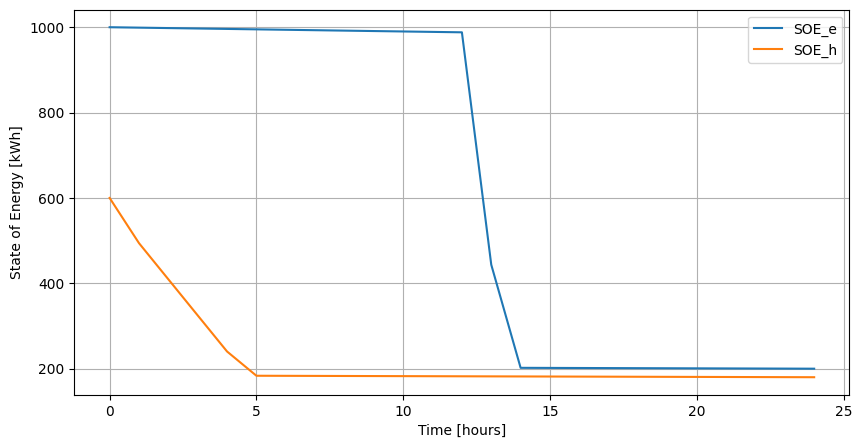

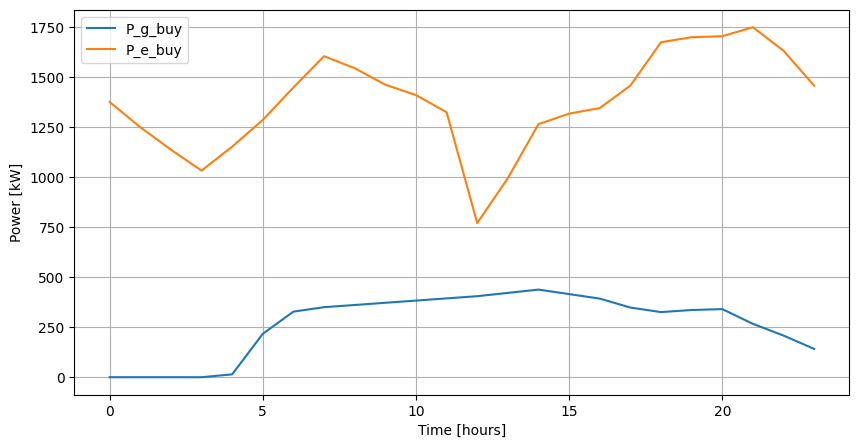

In [20]:
# reshape
u_sol = ca.reshape(solution['x'][:], n_controls, N)
xx_sol = ff(u_sol, args['p']) 


u_sol_np = np.array(u_sol)
xx_sol_np = np.array(xx_sol)


N_plus1 = xx_sol_np.shape[1]
time = np.arange(N_plus1) * step_horizon  # طول time = N+1


import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(time, xx_sol_np[0,:], label="SOE_e")
plt.plot(time, xx_sol_np[1,:], label="SOE_h")
plt.xlabel("Time [hours]")
plt.ylabel("State of Energy [kWh]")
plt.legend()
plt.grid()
plt.show()

# Plot of P_g_buy و P_e_buy (Controls)
plt.figure(figsize=(10,5))
plt.plot(time[:-1], u_sol_np[0,:], label="P_g_buy")

plt.plot(time[:-1], u_sol_np[1,:], label="P_e_buy")
plt.xlabel("Time [hours]")
plt.ylabel("Power [kW]")
plt.legend()
plt.grid()
plt.show()


In [21]:
solution

{'f': DM(7310.05),
 'g': DM([-2.82686e-48, 4.89016e-37, -5.09226e-47, -1.11602e-38, 1.22711e-45, 0, 0, 0, -5.68434e-14, 0, -5.29396e-23, -8.76879e-49, 2.71051e-20, -1.13687e-13, -2.55243e-14, 2.10349e-14, -3.45322e-48, 1.2926e-37, -2.67081e-47, 1.0739e-37, 2.02367e-46, 1.05879e-22, 1.05879e-22, 0, 0, 0, -5.29396e-23, -2.91909e-49, 0, 5.68434e-14, 1.45495e-14, 4.84543e-14, -1.56569e-47, -9.00283e-39, 8.88852e-47, -1.34063e-37, -1.22881e-47, 0, 0, 0, 0, 0, 0, 5.10138e-51, 0, 8.52651e-14, -1.1996e-14, -4.3293e-14, -4.2672e-48, 1.75161e-44, -8.24008e-47, -5.81293e-37, 4.65093e-46, 0, 0, 1.0842e-19, 0, 0, 0, 1.18466e-49, 1.0842e-19, 0, 2.29516e-14, -2.0486e-14, -7.01081e-48, -9.80257e-37, -1.40903e-48, -2.07011e-35, 2.49569e-42, 1.05879e-22, 1.05879e-22, 0, 0, 0, 0, -2.61012e-54, 0, -8.52651e-14, 1.90962e-14, 3.81711e-14, 1.25153e-47, 1.94871e-35, -7.38865e-47, -8.27555e-34, -2.18444e-42, 1.05879e-22, 1.05879e-22, 0, 5.68434e-14, 0, 0, 0, -2.84217e-14, -5.68434e-14, 1.16492e-14, 1.98347e-14

# MPC

In [23]:
from time import time as timer

t0 = 0
t1 = ca.DM(t0)

def shift_timestep(step_horizon, t0, initial_state, u, f):
    f_value = f(initial_state, u[:, 0])
    # print("f_value")
    # print(f_value)
    
    
    
    Gamma = ca.DM.eye(4) * 0.999 
    next_state = ca.DM.full(Gamma @ initial_state + step_horizon * f_value)

    # print(gamma*initial_state)
    print(initial_state)
    print(next_state)
    t0 = t0 + step_horizon
    u0 = ca.horzcat(
        u[:, 1:],
        ca.reshape(u[:, -1], -1, 1)
    )
    return t0, next_state, u0

def DM2Arr(dm):
    return np.array(dm.full())

X0 = ca.repmat(initial_state, 1, N+1)           # initial state full
system_states = DM2Arr(X0)
system_controls = DM2Arr(u0[:, 0])
mpc_iter = 0
times = np.array([[0]])

flag = 0
t = np.array([[t0]])   
###############################################################################
if __name__ == '__main__':
    main_loop = timer()
  # return time in sec
    while ((mpc_iter * step_horizon) < (hours - horizen_hours)):
        t1 = timer()
        args['p'] = ca.vertcat(
            initial_state,                              # current state
            target_state,                               # target state
            heat_load[mpc_iter:mpc_iter+N],             # Heat Load
            cool_load[mpc_iter:mpc_iter+N],
            electrical_load[mpc_iter:mpc_iter+N],       # Electrical Load 
            ce_buy[mpc_iter:mpc_iter+N],                # Electricity buy cost
            cg_buy[mpc_iter:mpc_iter+N],                # Gas buy cost  
            P_pv[mpc_iter:mpc_iter+N]                    # Sun Irradiation 
        )
        # u0 = ca.DM.zeros((n_controls, N))               # initial control       #############??????????????
        # X0 = ca.repmat(initial_state, 1, N+1)           # initial state full    #############??????????????
        # optimization variable current state
        args['x0'] = ca.vertcat(
            # ca.reshape(X0, n_states*(N+1), 1),
            ca.reshape(u0, n_controls*N, 1)
        )
        
        solution = solver(
            x0 = args['x0'],
            lbx = args['lbx'],
            ubx = args['ubx'],
            lbg = args['lbg'],
            ubg = args['ubg'],
            p = args['p']
        )

        u = ca.reshape(solution['x'][:], n_controls, N)
        X0 = ff(u,args['p'])
        # X0 = ca.reshape(solution['x'][: n_states * (N+1)], n_states, N+1)
        # cost = cost + solution['f']

        if(flag==0):
            uuu = u
            X0X0X0 = X0
            flag = 1
        
        system_states = np.dstack((
            system_states,
            DM2Arr(X0)
        ))
        # print(system_states)
        
        system_controls = np.vstack((
            system_controls,
            DM2Arr(u[:, 0])
        ))
        
        t = np.vstack((
            t,
            t0
        ))

        t0, initial_state, u0 = shift_timestep(step_horizon, t0, initial_state, u, f)   
        
        print("Hello")
        print(system_states)
        print(X0)
        print("Bye")
        
        X0 = ca.horzcat(
            # X0[:, 0:],
            X0[:, 1:],
            ca.reshape(X0[:, -1], -1, 1)
            # X0[:, -1]
        )
        
        # xx ...
        t2 = timer()
        print(mpc_iter)
        print(t2-t1)
        times = np.vstack((
            times,
            t2-t1
        ))

        mpc_iter = mpc_iter + 1
    
    main_loop_time = timer()
    ss_error = ca.norm_2(initial_state - target_state)

    print('\n\n')
    print('Total time: ', main_loop_time - main_loop)
    print('avg iteration time: ', np.array(times).mean() * 1000, 'ms')
    print('final error: ', ss_error)
    
    # # simulate
    # simulate(cat_states, cat_controls, times, step_horizon, N,
    #        np.array([x_init, y_init, theta_init, x_target, y_target, theta_target]), save=False)

# #                       0       1          2        3       4       5      6        7        8       9      10           11      12      13         14      15    16       17     18       19      20      21
# # controls = vertcat(P_g_buy, P_e_buy, P_e_sell, P_ch_e, P_dis_e, P_ch_h, P_dis_h, P_ch_i, P_dis_i, P_ch_g, P_dis_g,  P_e_CHP, P_g_CHP, P_h_CHP, P_h_GB, P_g_GB, P_h_EB, P_e_EB, P_c_EC, P_e_EC, P_h_AC, P_c_AC)


This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     1104
Number of nonzeros in inequality constraint Jacobian.:     2400
Number of nonzeros in Lagrangian Hessian.............:      120

Total number of variables............................:      552
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      552
                     variables with only upper bounds:        0
Total number of equality constraints.................:      384
Total number of inequality constraints...............:      100
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      100
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0169990e-01 2.10e+03 2.17e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

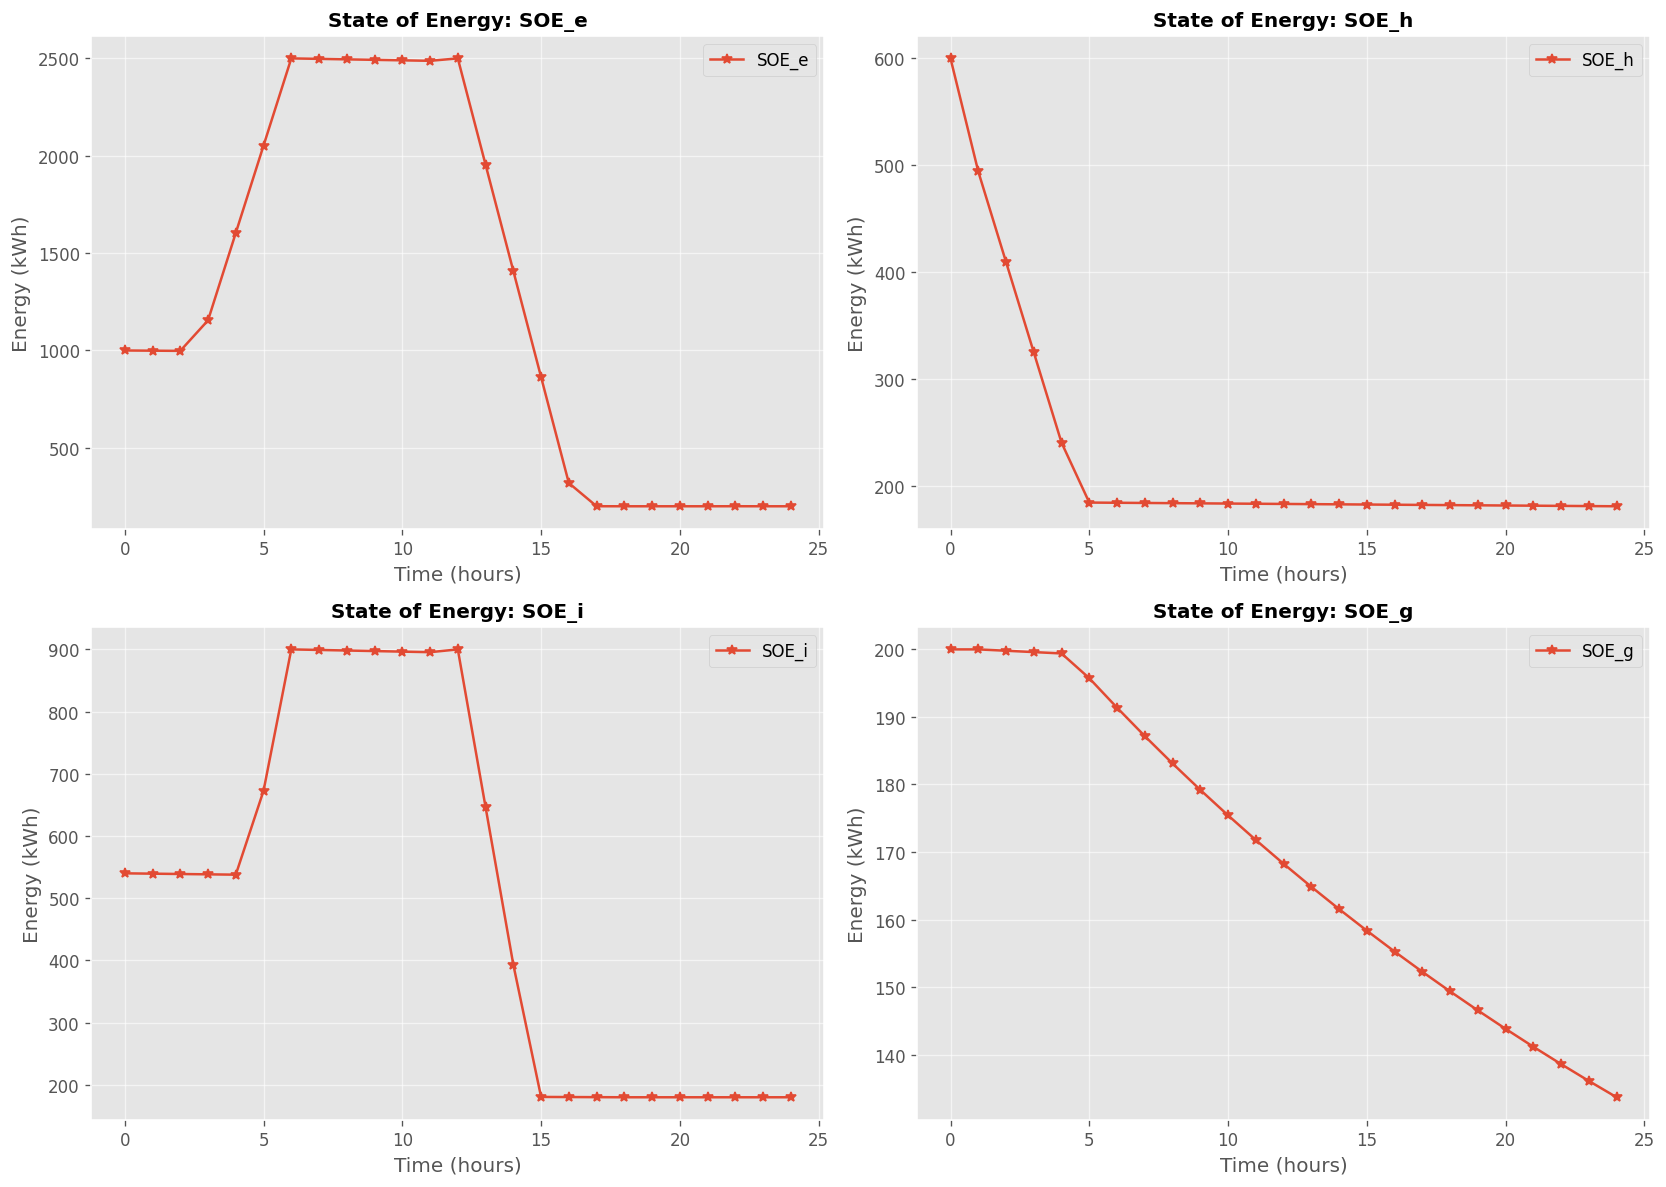

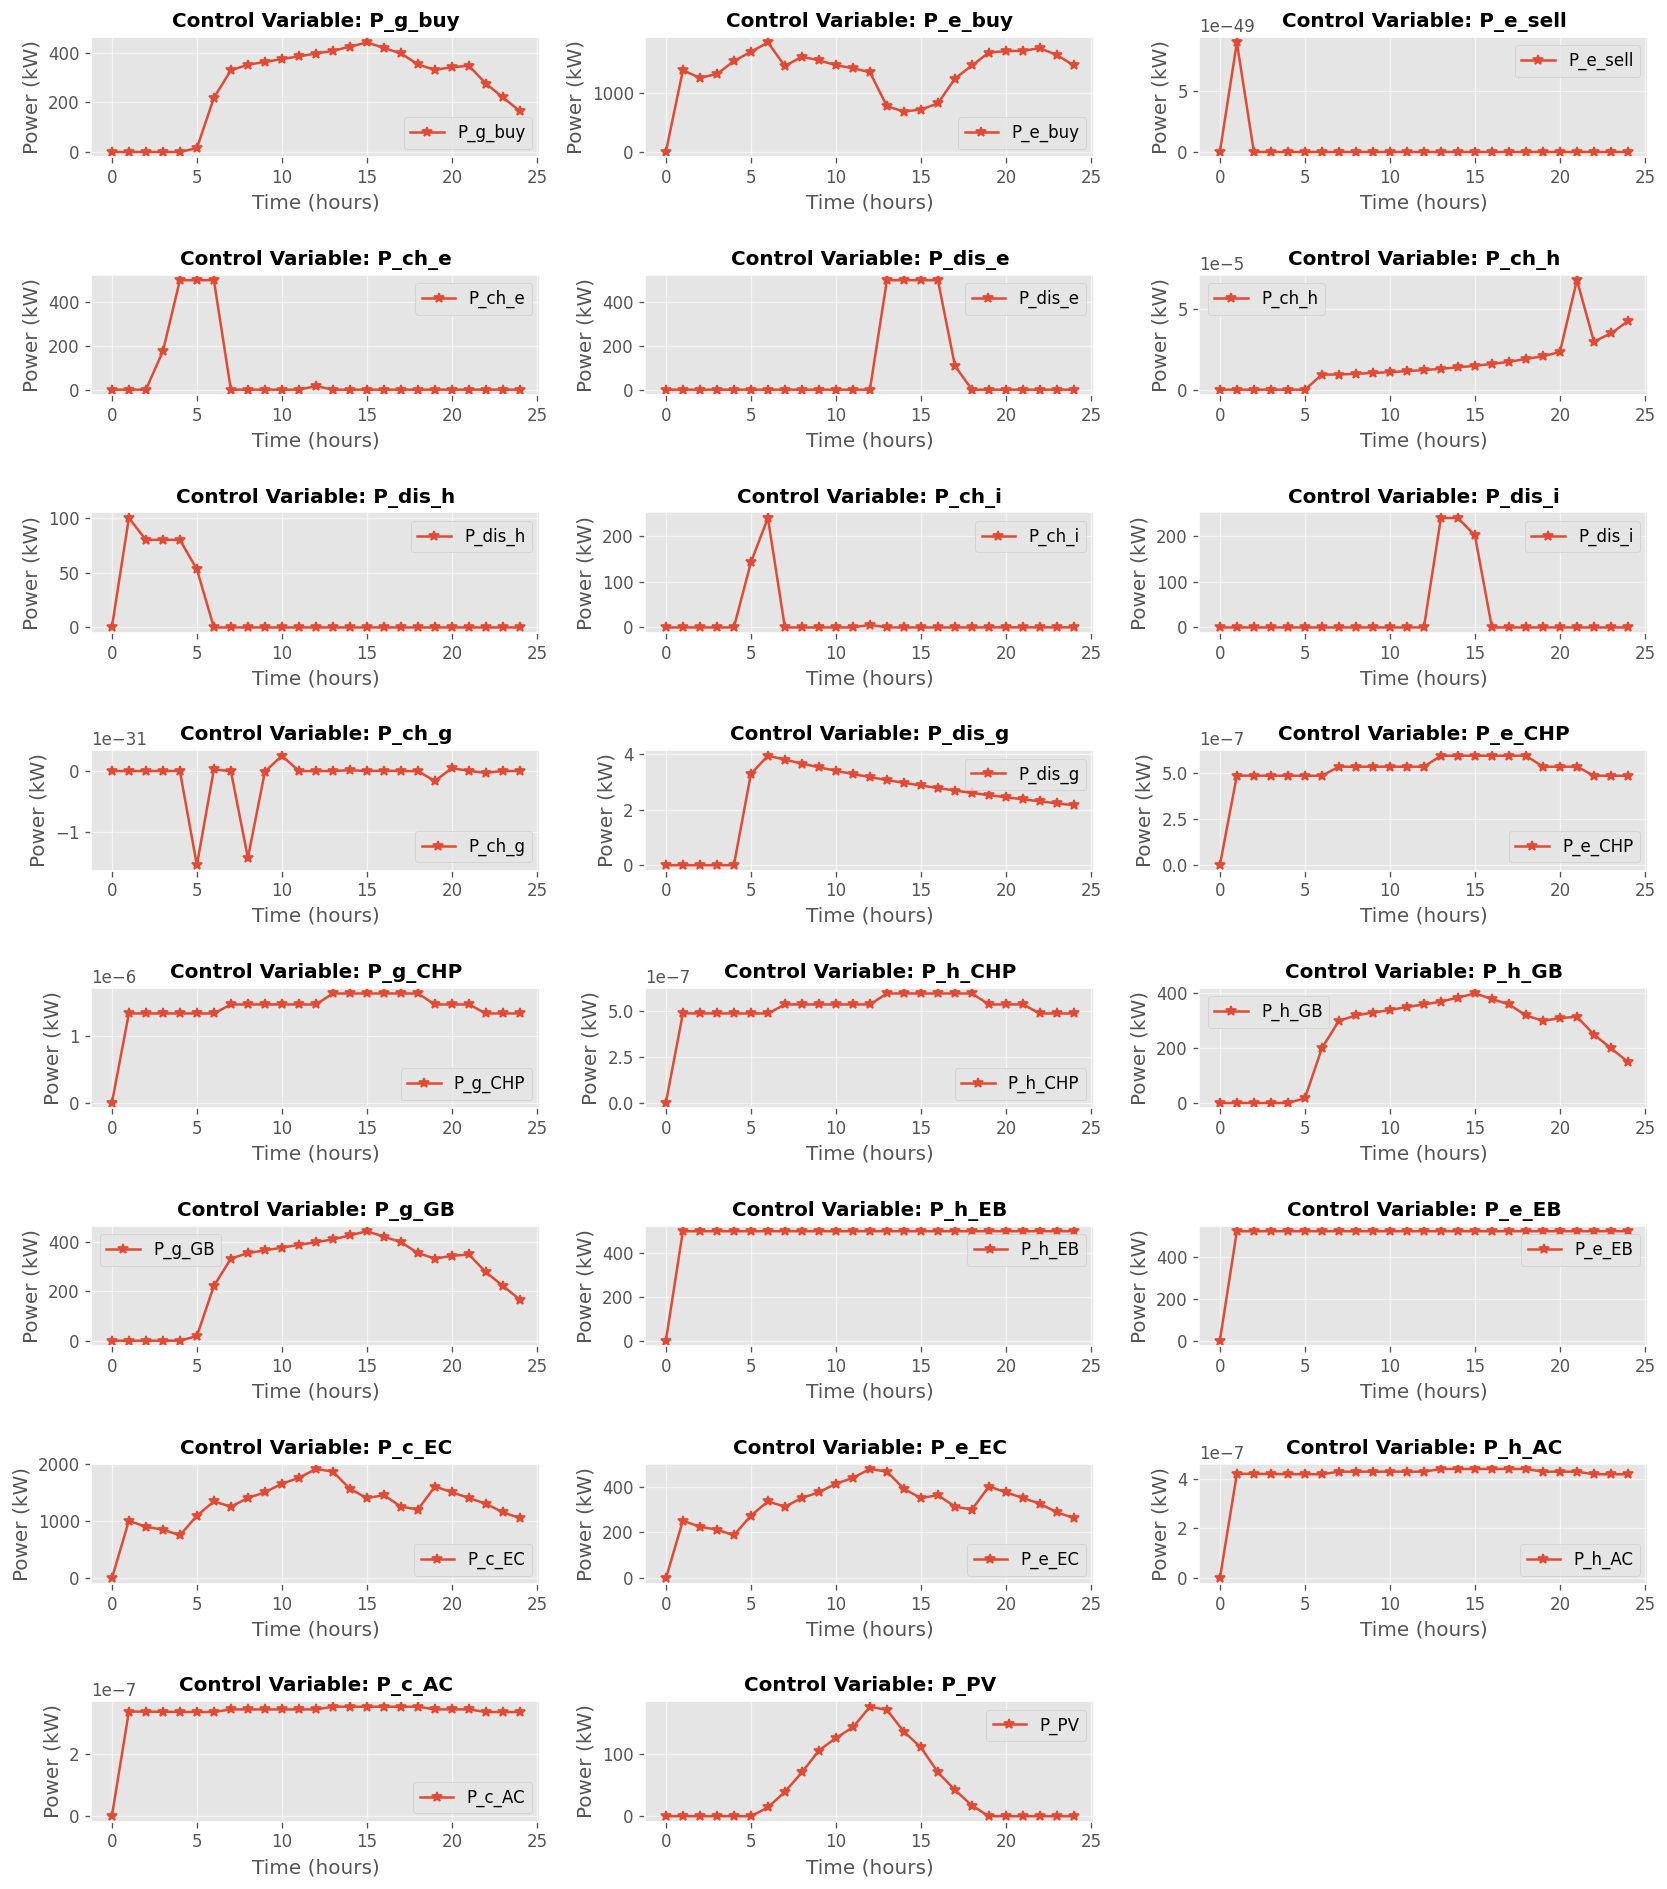

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# --- Display settings ---
plt.rcParams["figure.dpi"] = 120
plt.rcParams["font.size"] = 11
plt.style.use("ggplot")  # Use a clean matplotlib style similar to seaborn

# --- Extract State of Energy (SOE) for 4 storage units ---
SOE_e_sol = system_states[0,1,:]  # Electric storage
SOE_h_sol = system_states[1,1,:]  # Heat storage
SOE_i_sol = system_states[2,1,:]  # Industrial storage
SOE_g_sol = system_states[3,1,:]  # Gas storage

# --- Extract 22 control variables ---
P_g_buy_sol   = system_controls[0:len(system_controls):n_controls, 0]
P_e_buy_sol   = system_controls[1:len(system_controls):n_controls, 0]
P_e_sell_sol  = system_controls[2:len(system_controls):n_controls, 0]

P_ch_e_sol    = system_controls[3:len(system_controls):n_controls, 0]
P_dis_e_sol   = system_controls[4:len(system_controls):n_controls, 0]

P_ch_h_sol    = system_controls[5:len(system_controls):n_controls, 0]
P_dis_h_sol   = system_controls[6:len(system_controls):n_controls, 0]

P_ch_i_sol    = system_controls[7:len(system_controls):n_controls, 0]
P_dis_i_sol   = system_controls[8:len(system_controls):n_controls, 0]

P_ch_g_sol    = system_controls[9:len(system_controls):n_controls, 0]
P_dis_g_sol   = system_controls[10:len(system_controls):n_controls, 0]

P_e_CHP_sol   = system_controls[11:len(system_controls):n_controls, 0]
P_g_CHP_sol   = system_controls[12:len(system_controls):n_controls, 0]
P_h_CHP_sol   = system_controls[13:len(system_controls):n_controls, 0]

P_h_GB_sol    = system_controls[14:len(system_controls):n_controls, 0]
P_g_GB_sol    = system_controls[15:len(system_controls):n_controls, 0]

P_h_EB_sol    = system_controls[16:len(system_controls):n_controls, 0]
P_e_EB_sol    = system_controls[17:len(system_controls):n_controls, 0]

P_c_EC_sol    = system_controls[18:len(system_controls):n_controls, 0]
P_e_EC_sol    = system_controls[19:len(system_controls):n_controls, 0]

P_h_AC_sol    = system_controls[20:len(system_controls):n_controls, 0]
P_c_AC_sol    = system_controls[21:len(system_controls):n_controls, 0]

P_PV_sol      = system_controls[22:len(system_controls):n_controls, 0]

# --- Dictionary for State Variables ---
state_variables = {
    "SOE_e": SOE_e_sol,
    "SOE_h": SOE_h_sol,
    "SOE_i": SOE_i_sol,
    "SOE_g": SOE_g_sol, 
}

# --- Dictionary for Control Variables ---
control_variables = {
    "P_g_buy": P_g_buy_sol,
    "P_e_buy": P_e_buy_sol,
    "P_e_sell": P_e_sell_sol,
    "P_ch_e": P_ch_e_sol,
    "P_dis_e": P_dis_e_sol,
    "P_ch_h": P_ch_h_sol,
    "P_dis_h": P_dis_h_sol,
    "P_ch_i": P_ch_i_sol,
    "P_dis_i": P_dis_i_sol,
    "P_ch_g": P_ch_g_sol,
    "P_dis_g": P_dis_g_sol,
    "P_e_CHP": P_e_CHP_sol,
    "P_g_CHP": P_g_CHP_sol,
    "P_h_CHP": P_h_CHP_sol,
    "P_h_GB": P_h_GB_sol,
    "P_g_GB": P_g_GB_sol,
    "P_h_EB": P_h_EB_sol,
    "P_e_EB": P_e_EB_sol,
    "P_c_EC": P_c_EC_sol,
    "P_e_EC": P_e_EC_sol,
    "P_h_AC": P_h_AC_sol,
    "P_c_AC": P_c_AC_sol,
    "P_PV": P_PV_sol,
}

# --- Time vector ---
total_hours = hours - horizen_hours
data_points_per_hour = int(1 / step_horizon)
time = np.linspace(0, total_hours, total_hours * data_points_per_hour + 1)

# --- Plot State Variables ---
plt.figure(figsize=(14, len(state_variables) * 2.5))
marker_style = dict(marker='*', markersize=6, linestyle='-', linewidth=1.5)

for i, (label, data) in enumerate(state_variables.items(), 1):
    plt.subplot(2, 2, i)  # 2x2 subplot grid for 4 SOEs
    plt.plot(time, data.flatten(), label=label, **marker_style)
    plt.title(f"State of Energy: {label}", fontsize=12, weight='bold')
    plt.xlabel("Time (hours)")
    plt.ylabel("Energy (kWh)")
    plt.grid(alpha=0.6)
    plt.legend(loc="best", fontsize=10)

plt.tight_layout()
plt.savefig("State_Trajectories.png", dpi=300, bbox_inches="tight")
plt.show()

# --- Plot Control Variables ---
plt.figure(figsize=(14, int(len(control_variables)/3 + 1)*2))

for i, (label, data) in enumerate(control_variables.items(), 1):
    plt.subplot(int(len(control_variables)/3 + 0.67), 3, i)
    plt.plot(time, data.flatten(), label=label, **marker_style)
    plt.title(f"Control Variable: {label}", fontsize=12, weight='bold')
    plt.xlabel("Time (hours)")
    plt.ylabel("Power (kW)")
    plt.grid(alpha=0.6)
    plt.legend(loc="best", fontsize=10)

plt.tight_layout()
plt.savefig("Control_Trajectories.png", dpi=300, bbox_inches="tight")
plt.show()


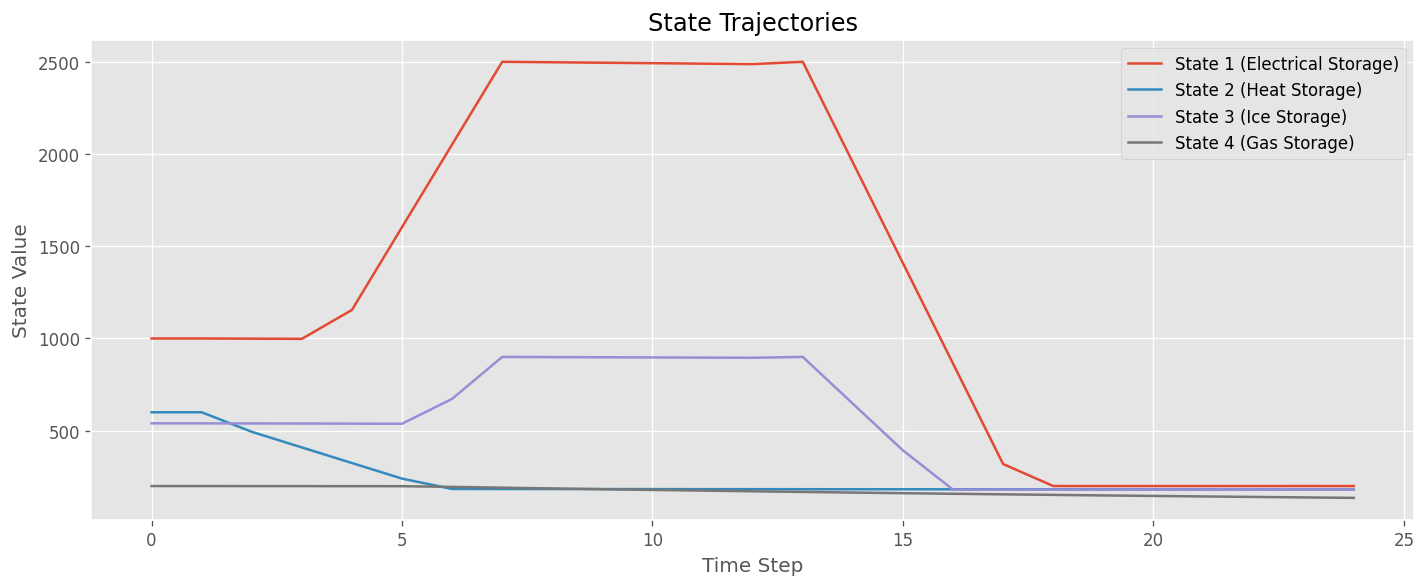

In [25]:
import matplotlib.pyplot as plt

# ---- State trajectories ----
plt.figure(figsize=(12,5))

state_labels = [
    "State 1 (Electrical Storage)",
    "State 2 (Heat Storage)",
    "State 3 (Ice Storage)",
    "State 4 (Gas Storage)"
]

for i in range(n_states):
    plt.plot(system_states[i,0,:], label=state_labels[i])

plt.legend()
plt.xlabel("Time Step")
plt.ylabel("State Value")
plt.title("State Trajectories")
plt.grid(True)
plt.tight_layout()
plt.savefig("state_trajectories_together.png") 



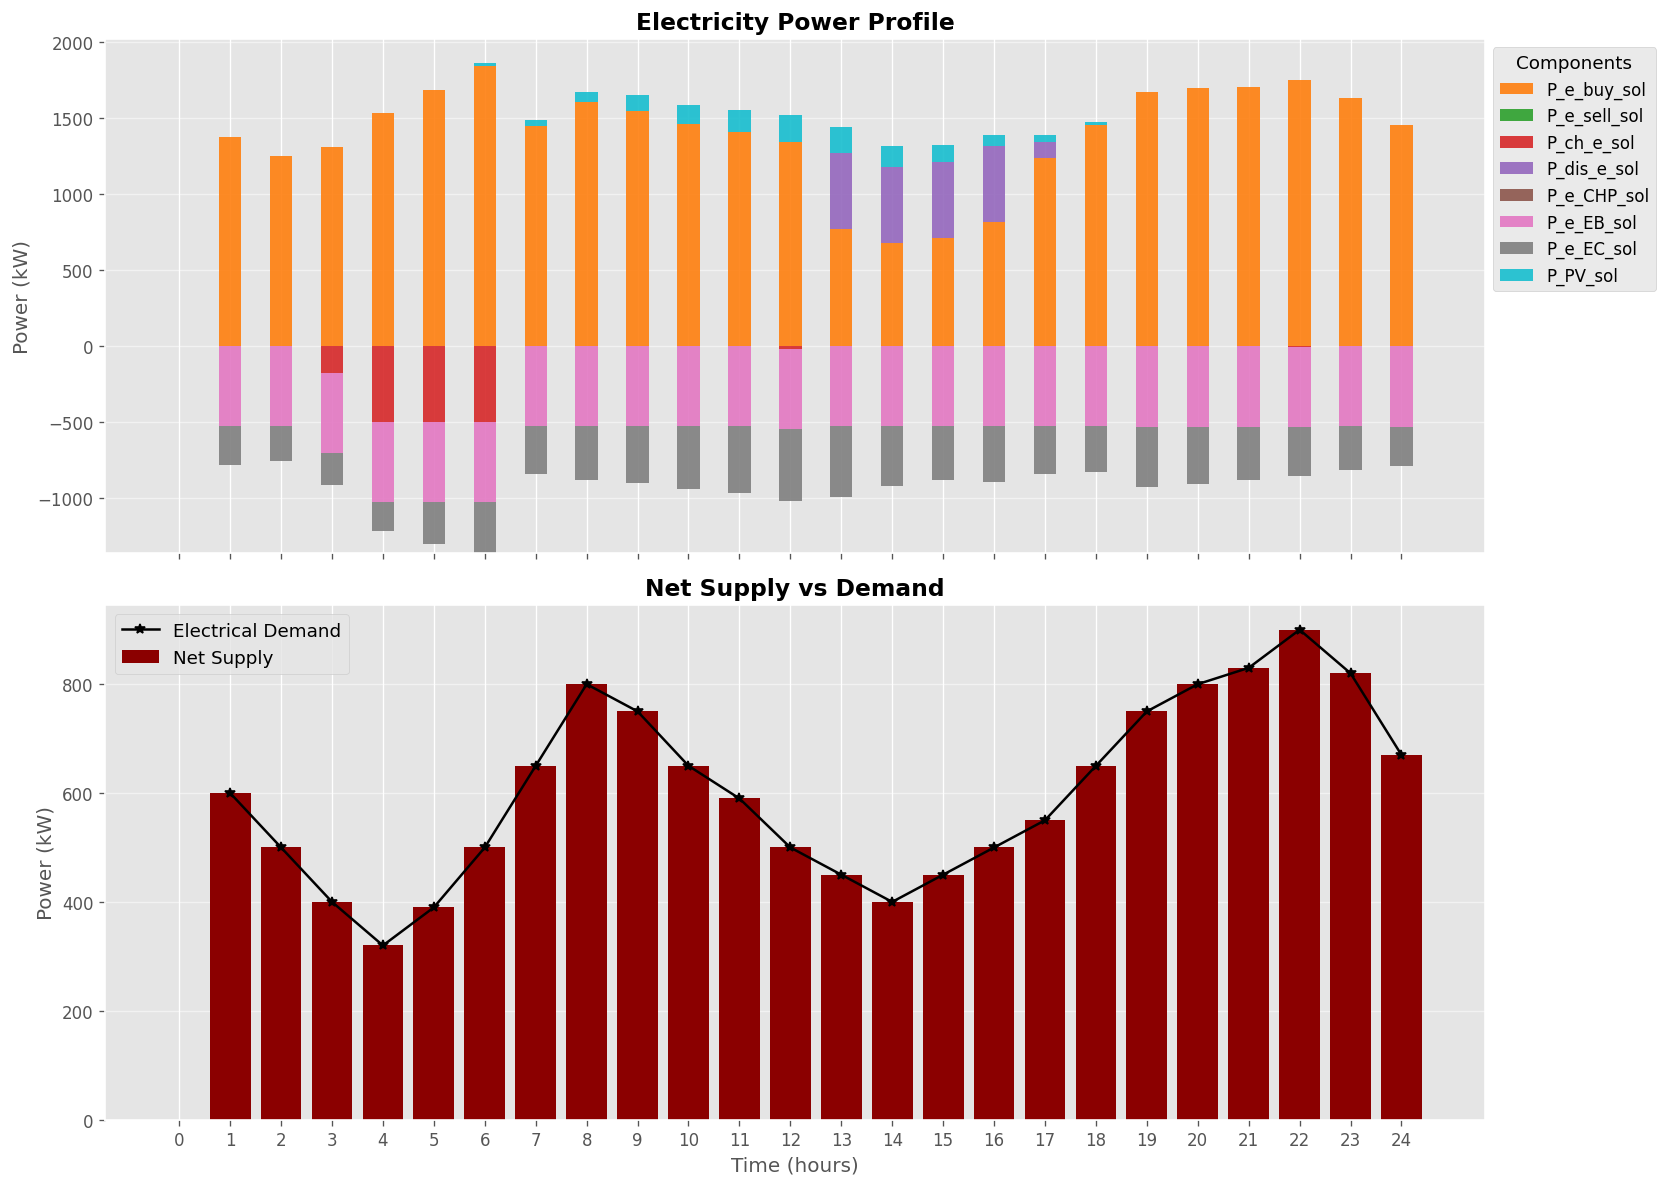

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# --- Define electricity supply components for load demand ---
variables_e = {
    "P_e_buy_sol": P_e_buy_sol,
    "P_e_sell_sol": -P_e_sell_sol,      # Selling is negative contribution
    "P_ch_e_sol": -P_ch_e_sol,          # Charging storage reduces net supply
    "P_dis_e_sol": P_dis_e_sol,         # Discharging storage adds to supply
    "P_e_CHP_sol": P_e_CHP_sol,
    "P_e_EB_sol": -P_e_EB_sol,
    "P_e_EC_sol": -P_e_EC_sol,
    "P_PV_sol": P_PV_sol,
}

# --- Custom color palette ---
custom_colors = {
    "P_e_buy_sol": "#ff7f0e",   # Orange
    "P_e_sell_sol": "#2ca02c",  # Green
    "P_ch_e_sol": "#d62728",    # Red
    "P_dis_e_sol": "#9467bd",   # Purple
    "P_e_CHP_sol": "#8c564b",   # Brown
    "P_e_EB_sol": "#e377c2",    # Pink
    "P_e_EC_sol": "#7f7f7f",    # Gray
    "P_PV_sol": "#17becf",          # Cyan
}

# --- Prepare data ---
data = np.array([values for values in variables_e.values()])
net_supply = data.sum(axis=0)   # Net supply = sum of all components
t_ctrl = time[:-1] 
elec_demand = np.array(electrical_load)[:len(time)]

labels = list(variables_e.keys())
positive_data = np.where(data > 0, data, 0)
negative_data = np.where(data < 0, data, 0)

# --- Create subplots ---
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# --- Plot 1: stacked bars (components) ---
bar_width = 0.44
cumulative_positive = np.zeros(data.shape[1])
for i, label in enumerate(labels):
    axes[0].bar(time, positive_data[i], bottom=cumulative_positive,
                label=label, color=custom_colors[label], alpha=0.9, width=bar_width)
    cumulative_positive += positive_data[i]

cumulative_negative = np.zeros(data.shape[1])
for i, label in enumerate(labels):
    axes[0].bar(time, negative_data[i], bottom=cumulative_negative,
                color=custom_colors[label], alpha=0.9, width=bar_width)
    cumulative_negative += negative_data[i]

axes[0].set_title("Electricity Power Profile", fontsize=14, weight="bold")
axes[0].set_ylabel("Power (kW)", fontsize=12)
axes[0].grid(axis="y", alpha=0.5)
axes[0].legend(title="Components", fontsize=10, title_fontsize=11, loc="upper left", bbox_to_anchor=(1, 1))

# --- Plot 2: Net supply as bar, demand as star line ---
axes[1].bar(time[1:], net_supply[1:], color='darkred', label="Net Supply", width=0.8)
axes[1].plot(time[1:], elec_demand[:-1], '*-', color='black', label="Electrical Demand", linewidth=1.5)

axes[1].set_title("Net Supply vs Demand", fontsize=14, weight="bold")
axes[1].set_xlabel("Time (hours)", fontsize=12)
axes[1].set_ylabel("Power (kW)", fontsize=12)
axes[1].grid(axis="y", alpha=0.5)
axes[1].legend(fontsize=11)


# X-axis ticks (whole hours)
whole_hours_indices = [i for i, t in enumerate(time) if t % 1 == 0]
axes[1].set_xticks([time[i] for i in whole_hours_indices])

plt.tight_layout()
plt.savefig("1.png")
plt.show()




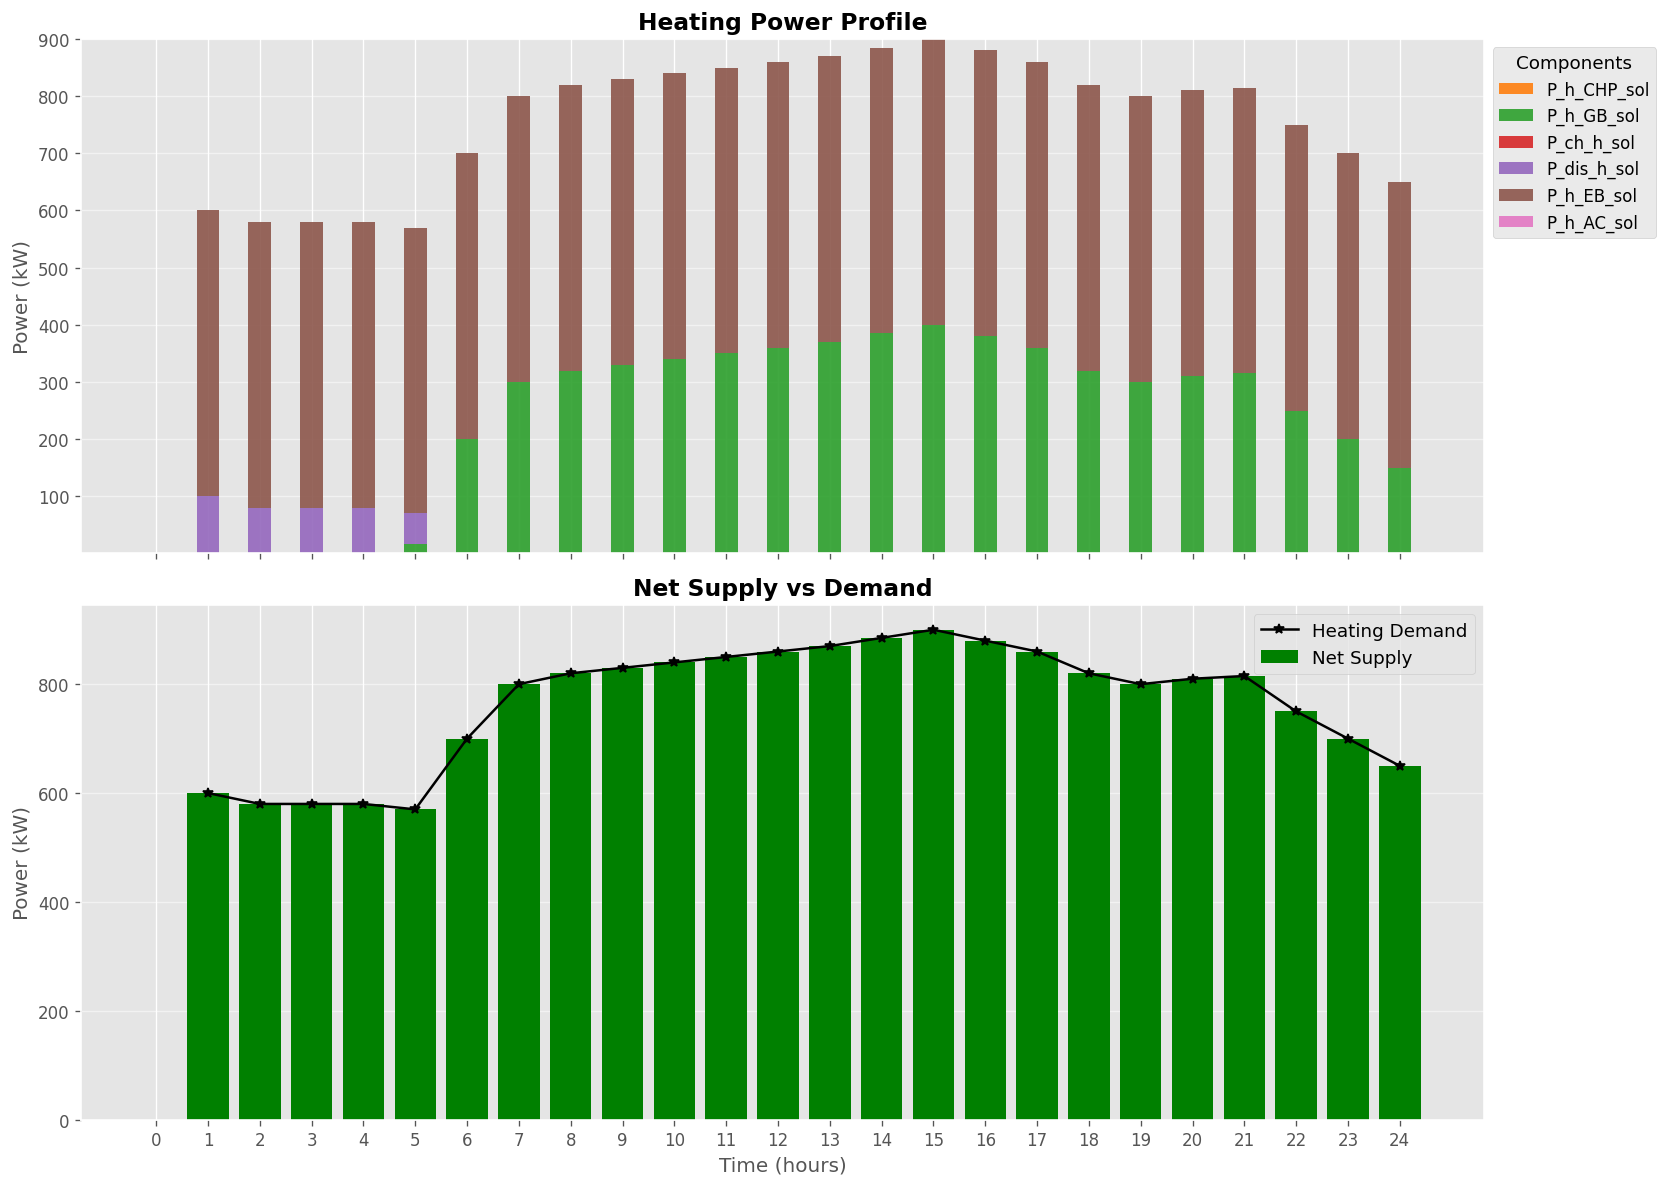

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# --- Define heat supply components for load demand ---
variables_h = {
    
    "P_h_CHP_sol": P_h_CHP_sol,
    "P_h_GB_sol":  P_h_GB_sol,
    "P_ch_h_sol": -P_ch_h_sol,          # Charging storage reduces net supply
    "P_dis_h_sol": P_dis_h_sol,         # Discharging storage adds to supply
    "P_h_EB_sol": P_h_EB_sol,
    "P_h_AC_sol": -P_h_AC_sol,
}

# --- Custom color palette ---
custom_colors = {
    "P_h_CHP_sol": "#ff7f0e",   # Orange
    "P_h_GB_sol": "#2ca02c",  # Green
    "P_ch_h_sol": "#d62728",    # Red
    "P_dis_h_sol": "#9467bd",   # Purple
    "P_h_EB_sol": "#8c564b",   # Brown
    "P_h_AC_sol": "#e377c2",    # Pink
}

# --- Prepare data ---
data = np.array([values for values in variables_h.values()])
net_supply = data.sum(axis=0)   # Net supply = sum of all components
heat_demand = np.array(heat_load)[:len(time)]

labels = list(variables_h.keys())
positive_data = np.where(data > 0, data, 0)
negative_data = np.where(data < 0, data, 0)

# --- Create subplots ---
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# --- Plot 1: stacked bars (components) ---
bar_width = 0.44
cumulative_positive = np.zeros(data.shape[1])
for i, label in enumerate(labels):
    axes[0].bar(time, positive_data[i], bottom=cumulative_positive,
                label=label, color=custom_colors[label], alpha=0.9, width=bar_width)
    cumulative_positive += positive_data[i]

cumulative_negative = np.zeros(data.shape[1])
for i, label in enumerate(labels):
    axes[0].bar(time, negative_data[i], bottom=cumulative_negative,
                color=custom_colors[label], alpha=0.9, width=bar_width)
    cumulative_negative += negative_data[i]

axes[0].set_title("Heating Power Profile", fontsize=14, weight="bold")
axes[0].set_ylabel("Power (kW)", fontsize=12)
axes[0].grid(axis="y", alpha=0.5)
axes[0].legend(title="Components", fontsize=10, title_fontsize=11, loc="upper left", bbox_to_anchor=(1, 1))

# --- Plot 2: Net supply as bar, demand as star line ---
axes[1].bar(time[1:], net_supply[1:], color='green', label="Net Supply", width=0.8)
axes[1].plot(time[1:], heat_demand[:-1], '*-', color='black', label="Heating Demand", linewidth=1.5)

axes[1].set_title("Net Supply vs Demand", fontsize=14, weight="bold")
axes[1].set_xlabel("Time (hours)", fontsize=12)
axes[1].set_ylabel("Power (kW)", fontsize=12)
axes[1].grid(axis="y", alpha=0.5)
axes[1].legend(fontsize=11)


# X-axis ticks (whole hours)
whole_hours_indices = [i for i, t in enumerate(time) if t % 1 == 0]
axes[1].set_xticks([time[i] for i in whole_hours_indices])

plt.tight_layout()
plt.savefig("2.png")
plt.show()


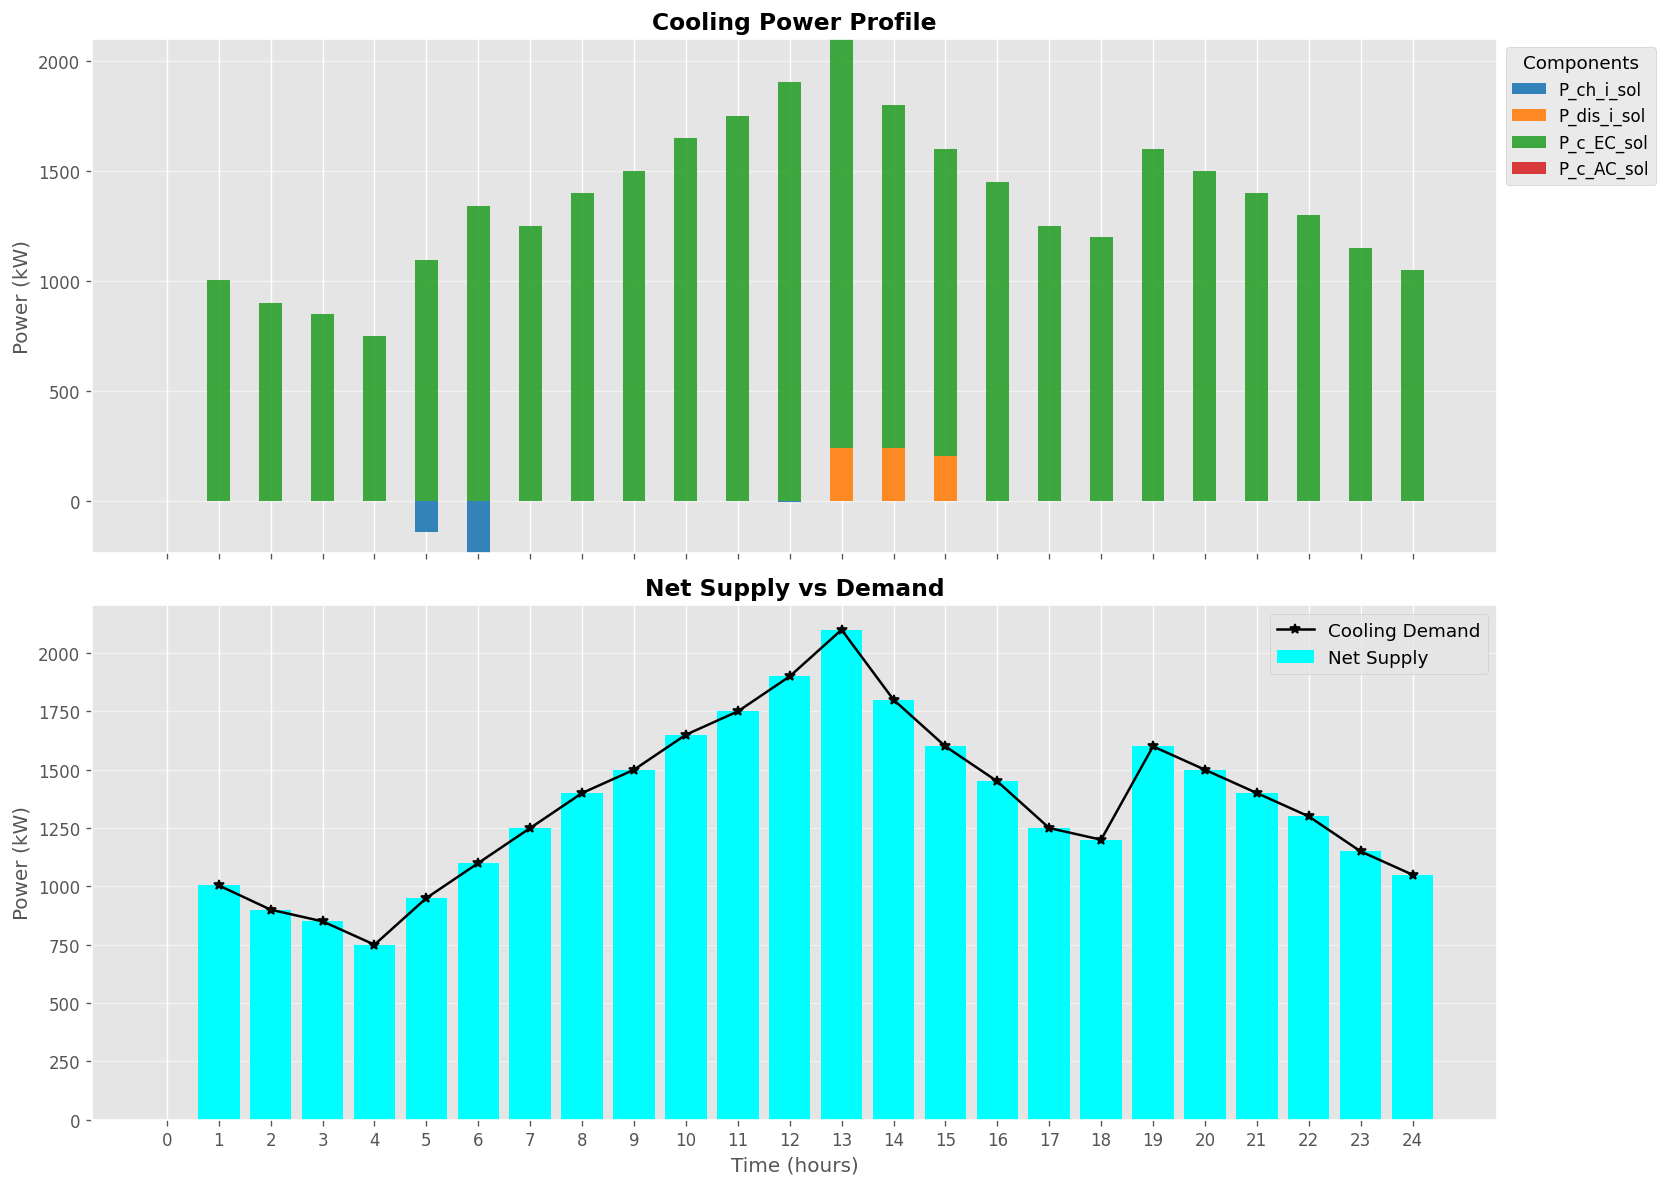

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# --- Define cool supply components for load demand ---
variables_c = {
    "P_ch_i_sol": -P_ch_i_sol,      # Charging reduces net cooling
    "P_dis_i_sol": P_dis_i_sol,     # Discharging adds cooling
    "P_c_EC_sol":  P_c_EC_sol,       # Electrical cooling
    "P_c_AC_sol":  P_c_AC_sol,      # AC reduces net supply
}

# --- Custom color palette ---
custom_colors = {
    "P_ch_i_sol": "#1f77b4",   # Blue
    "P_dis_i_sol": "#ff7f0e",  # Orange
    "P_c_EC_sol": "#2ca02c",   # Green
    "P_c_AC_sol": "#d62728",   # Red
}

# --- Prepare data ---
data = np.array([values for values in variables_c.values()])
net_supply = data.sum(axis=0)   # Net supply = sum of all components
cool_demand = np.array(cool_load)[:len(time)]

labels = list(variables_c.keys())
positive_data = np.where(data > 0, data, 0)
negative_data = np.where(data < 0, data, 0)

# --- Create subplots ---
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# --- Plot 1: stacked bars (components) ---
bar_width = 0.44
cumulative_positive = np.zeros(data.shape[1])
for i, label in enumerate(labels):
    axes[0].bar(time, positive_data[i], bottom=cumulative_positive,
                label=label, color=custom_colors[label], alpha=0.9, width=bar_width)
    cumulative_positive += positive_data[i]

cumulative_negative = np.zeros(data.shape[1])
for i, label in enumerate(labels):
    axes[0].bar(time, negative_data[i], bottom=cumulative_negative,
                color=custom_colors[label], alpha=0.9, width=bar_width)
    cumulative_negative += negative_data[i]

axes[0].set_title("Cooling Power Profile", fontsize=14, weight="bold")
axes[0].set_ylabel("Power (kW)", fontsize=12)
axes[0].grid(axis="y", alpha=0.5)
axes[0].legend(title="Components", fontsize=10, title_fontsize=11, loc="upper left", bbox_to_anchor=(1, 1))

# --- Plot 2: Net supply as bar, demand as star line ---
axes[1].bar(time[1:], net_supply[1:], color='cyan', label="Net Supply", width=0.8)
axes[1].plot(time[1:], cool_demand[:-1], '*-', color='black', label="Cooling Demand", linewidth=1.5)

axes[1].set_title("Net Supply vs Demand", fontsize=14, weight="bold")
axes[1].set_xlabel("Time (hours)", fontsize=12)
axes[1].set_ylabel("Power (kW)", fontsize=12)
axes[1].grid(axis="y", alpha=0.5)
axes[1].legend(fontsize=11)


# X-axis ticks (whole hours)
whole_hours_indices = [i for i, t in enumerate(time) if t % 1 == 0]
axes[1].set_xticks([time[i] for i in whole_hours_indices])

plt.tight_layout()
plt.savefig("3.png")
plt.show()


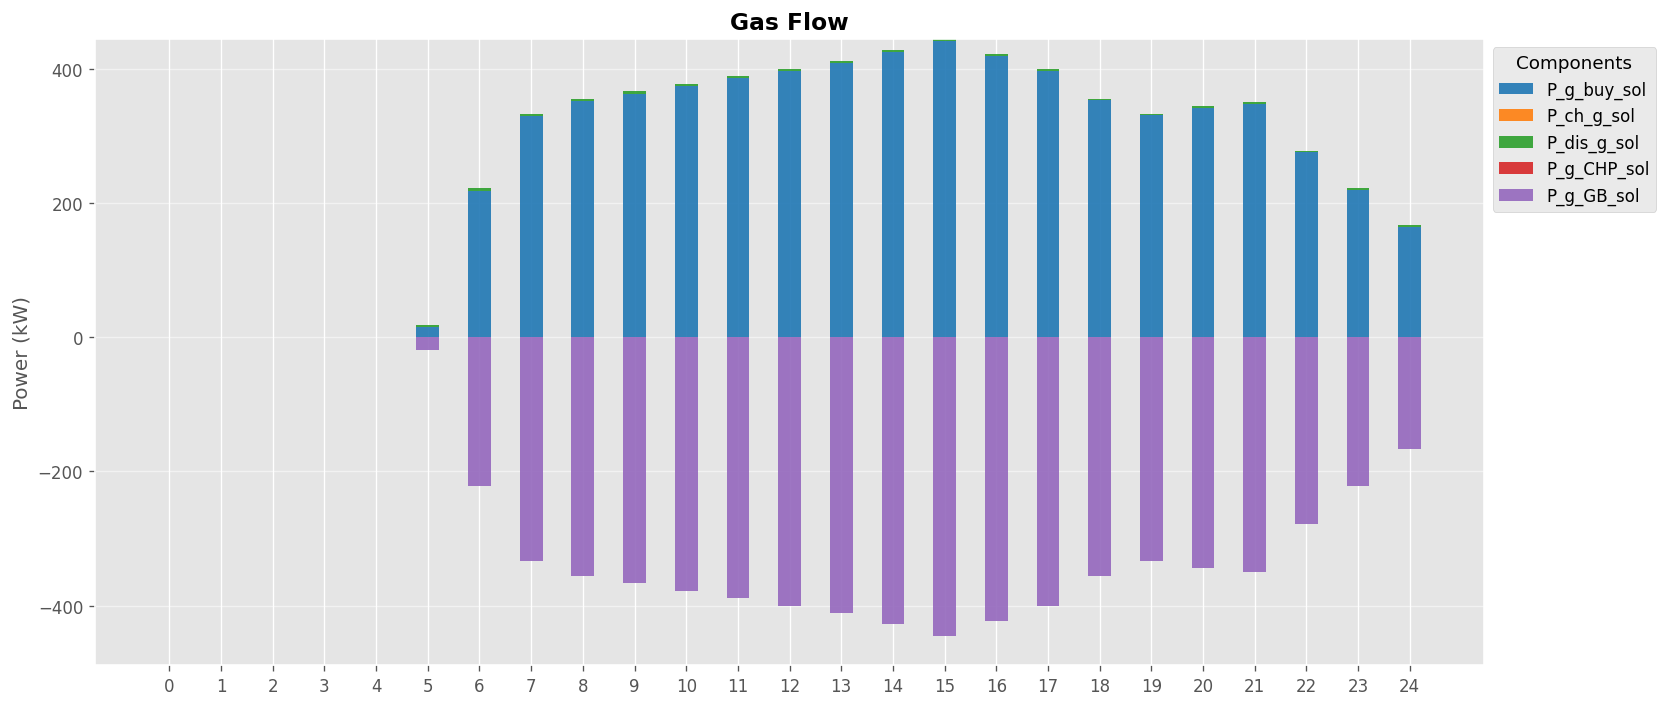

In [32]:
import matplotlib.pyplot as plt
import numpy as np

# --- Define gas supply components ---
variables_g = { 
    "P_g_buy_sol": P_g_buy_sol,
    "P_ch_g_sol": -P_ch_g_sol,       
    "P_dis_g_sol": P_dis_g_sol,     
    "P_g_CHP_sol": -P_g_CHP_sol,        
    "P_g_GB_sol": -P_g_GB_sol,      
}

# --- Custom color palette ---
custom_colors = {
    "P_g_buy_sol": "#1f77b4",   # Blue
    "P_ch_g_sol": "#ff7f0e",    # Orange
    "P_dis_g_sol": "#2ca02c",   # Green
    "P_g_CHP_sol": "#d62728",   # Red
    "P_g_GB_sol": "#9467bd",    # Purple
}

# --- Prepare data ---
data = np.array([values for values in variables_g.values()])

labels = list(variables_g.keys())
positive_data = np.where(data > 0, data, 0)
negative_data = np.where(data < 0, data, 0)

# --- Create single plot ---
plt.figure(figsize=(14,6))

bar_width = 0.44
cumulative_positive = np.zeros(data.shape[1])
for i, label in enumerate(labels):
    plt.bar(time, positive_data[i], bottom=cumulative_positive,
            label=label, color=custom_colors[label], alpha=0.9, width=bar_width)
    cumulative_positive += positive_data[i]

cumulative_negative = np.zeros(data.shape[1])
for i, label in enumerate(labels):
    plt.bar(time, negative_data[i], bottom=cumulative_negative,
            color=custom_colors[label], alpha=0.9, width=bar_width)
    cumulative_negative += negative_data[i]

plt.title("Gas Flow", fontsize=14, weight="bold")
plt.ylabel("Power (kW)", fontsize=12)
plt.grid(axis="y", alpha=0.5)
plt.legend(title="Components", fontsize=10, title_fontsize=11, loc="upper left", bbox_to_anchor=(1, 1))

# X-axis ticks (whole hours)
whole_hours_indices = [i for i, t in enumerate(time) if t % 1 == 0]
plt.xticks([time[i] for i in whole_hours_indices])

plt.tight_layout()
plt.savefig("4.png")
plt.show()


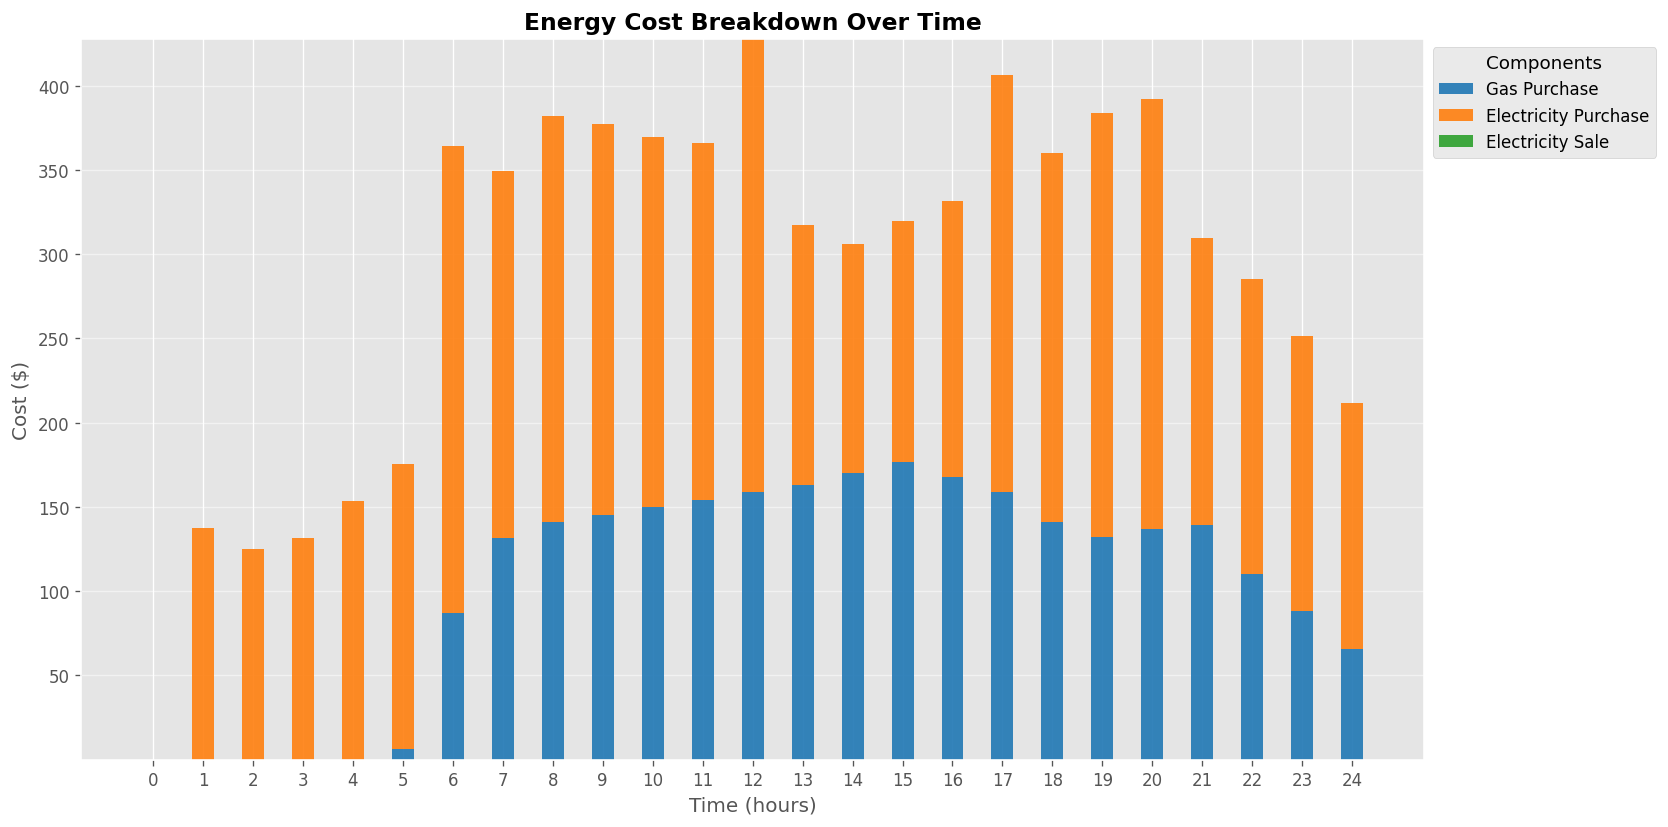

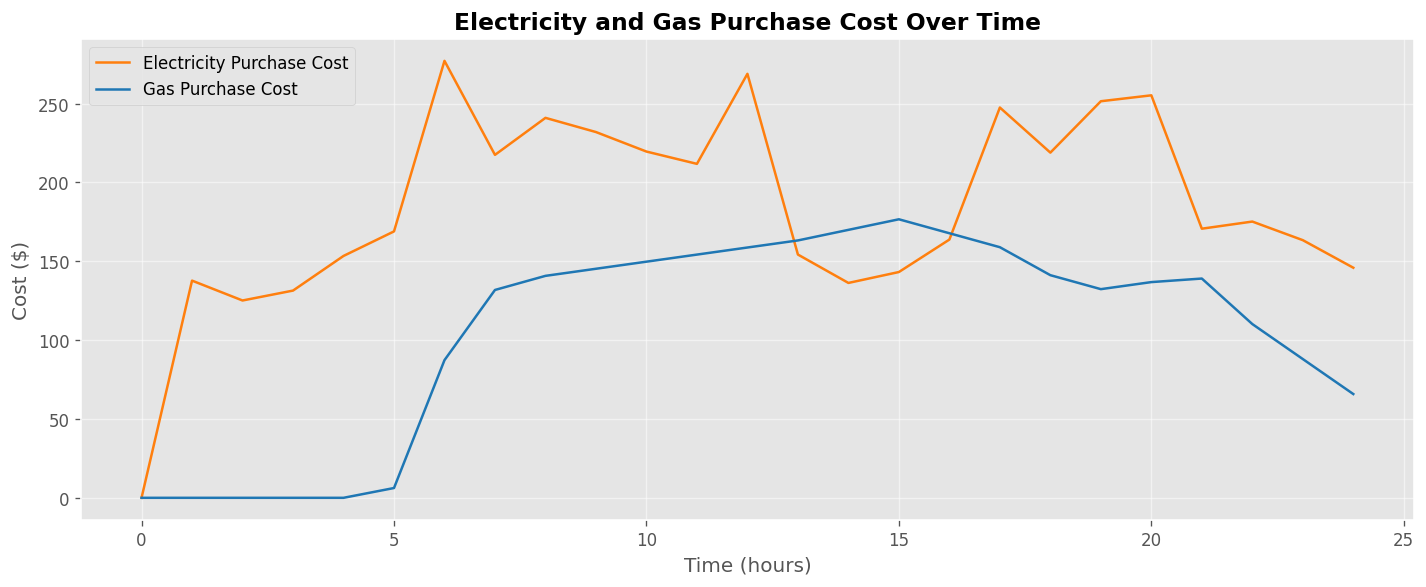

In [33]:
import matplotlib.pyplot as plt
import numpy as np

# --- Define cost components ---
variables_cost = {
    "Gas Purchase": cg_buy[:len(P_g_buy_sol)] * P_g_buy_sol,
    "Electricity Purchase": ce_buy[:len(P_e_buy_sol)] * P_e_buy_sol,
    "Electricity Sale": -ce_sell * P_e_sell_sol,
}

# --- Custom color palette ---
custom_colors = {
    "Gas Purchase": "#1f77b4",   # Blue
    "Electricity Purchase": "#ff7f0e",  # Orange
    "Electricity Sale": "#2ca02c", # Green
}

# --- Prepare data ---
data = np.array([values for values in variables_cost.values()])
labels = list(variables_cost.keys())
positive_data = np.where(data > 0, data, 0)
negative_data = np.where(data < 0, data, 0)

# --- Main plot: cost breakdown ---
plt.figure(figsize=(14, 7))
bar_width = 0.44

cumulative_positive = np.zeros(data.shape[1])
for i, label in enumerate(labels):
    plt.bar(time, positive_data[i], bottom=cumulative_positive,
            label=label, color=custom_colors[label], alpha=0.9, width=bar_width)
    cumulative_positive += positive_data[i]

cumulative_negative = np.zeros(data.shape[1])
for i, label in enumerate(labels):
    plt.bar(time, negative_data[i], bottom=cumulative_negative,
            color=custom_colors[label], alpha=0.9, width=bar_width)
    cumulative_negative += negative_data[i]

plt.title("Energy Cost Breakdown Over Time", fontsize=14, weight="bold")
plt.xlabel("Time (hours)", fontsize=12)
plt.ylabel("Cost ($)", fontsize=12)
plt.grid(axis="y", alpha=0.5)

# X-axis ticks (whole hours)
whole_hours_indices = [i for i, t in enumerate(time) if t % 1 == 0]
plt.xticks([time[i] for i in whole_hours_indices])

plt.legend(title="Components", fontsize=10, title_fontsize=11, loc="upper left", bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.savefig("5.png", dpi=300)

import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

# Electricity Purchase Cost
plt.plot(time, variables_cost["Electricity Purchase"], color="#ff7f0e", label="Electricity Purchase Cost")

# Gas Purchase Cost
plt.plot(time, variables_cost["Gas Purchase"], color="#1f77b4", label="Gas Purchase Cost")

# Titles and labels
plt.title("Electricity and Gas Purchase Cost Over Time", fontsize=14, weight="bold")
plt.xlabel("Time (hours)", fontsize=12)
plt.ylabel("Cost ($)", fontsize=12)
plt.grid(True, alpha=0.5)

# Legend
plt.legend()

plt.tight_layout()
plt.savefig("combined_cost.png", dpi=300)
plt.show()

